In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.nn import init
import sys

In [ ]:
%cd /content/drive/My\ Drive/Segmentation

/content/drive/My Drive/Segmentation


In [ ]:
from layers import *

In [ ]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
device

device(type='cuda')

#Dataset


In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import torch
import nibabel as nib
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import random


train_transform_toinput = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.ToTensor()
        ])

class BrainCTDataset_train(Dataset):

    def __init__(self, csv_file, root_dir, transform2 = None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform2 = transform2

    def __len__(self):
        return len(self.data_frame)
    
    def transform(self, image, mask):
        # Resize
        image = transforms.ToPILImage()(image)
        mask = transforms.ToPILImage()(mask)
        
        resize = transforms.Resize(size=(256, 256))
        image = resize(image)
        mask =  resize(mask)

       

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # Random rotate
        if random.random() > 0.5:
            angle = random.randint(-30, 30)
            image = TF.rotate(image, angle, fill=(0,))
            mask = TF.rotate(mask, angle, fill=(0,))
            
        #mask = transforms.CenterCrop(162)(mask)
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        # image = 255*image
        # normalize = transforms.Normalize([0.5], [0.25])
        # image = normalize(image)
        
        #mask = 255*mask
        return image, mask

    def __getitem__(self, idx):
        img_CTtype_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])
        i = self.data_frame.iloc[idx, 4]
        
        image_CTtype = nib.load(img_CTtype_name)
        img_arr_CTtype=image_CTtype.get_fdata()
        img_arr_CTtype = np.array(img_arr_CTtype)
        img_CTtype_2d = img_arr_CTtype[:,:,i].transpose((1,0))
        img_CTtype_2d = np.uint8(img_CTtype_2d[..., None])
            
        img_label_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 2])
        
        image_label = nib.load(img_label_name)
        img_arr_label=image_label.get_fdata()
        img_arr_label = np.array(img_arr_label)
        img_label_2d = img_arr_label[:,:,i].transpose((1,0))
        img_label_2d = np.uint8(img_label_2d[..., None])
        
        img, label = self.transform(img_CTtype_2d, img_label_2d)
        
        if self.transform2:
            img = self.transform2(img)
        
        sample = {'x': img, 'y': label}
        
        return sample

In [ ]:
validate_transform_toinput = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.ToTensor()
        ])

class BrainCTDataset_validate(Dataset):

    def __init__(self, csv_file, root_dir, transform2 = None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform2 = transform2

    def __len__(self):
        return len(self.data_frame)
    
    def transform(self, image, mask):
        # Resize
        image = transforms.ToPILImage()(image)
        mask = transforms.ToPILImage()(mask)
        
        resize = transforms.Resize(size=(256, 256))
        image = resize(image)
        mask = resize(mask)
            
        #mask = transforms.CenterCrop(162)(mask)
        
        # Transform to tensor
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        # image = 255*image
        # normalize = transforms.Normalize([0.5], [0.25])
        # image = normalize(image)
        
        #mask = 255*mask
        return image, mask

    def __getitem__(self, idx):
        img_CTtype_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])
        i = self.data_frame.iloc[idx, 4]
        
        image_CTtype = nib.load(img_CTtype_name)
        img_arr_CTtype=image_CTtype.get_fdata()
        img_arr_CTtype = np.array(img_arr_CTtype)
        img_CTtype_2d = img_arr_CTtype[:,:,i].transpose((1,0))
        img_CTtype_2d = np.uint8(img_CTtype_2d[..., None])
            
        img_label_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 2])
        
        image_label = nib.load(img_label_name)
        img_arr_label=image_label.get_fdata()
        img_arr_label = np.array(img_arr_label)
        img_label_2d = img_arr_label[:,:,i].transpose((1,0))
        img_label_2d = np.uint8(img_label_2d[..., None])
        
        img, label = self.transform(img_CTtype_2d, img_label_2d)
        
        if self.transform2:
            img = self.transform2(img)
        
        sample = {'x': img, 'y': label}
        
        return sample

# Load

In [ ]:
train_csv_path = '/content/drive/My Drive/data/train_dataloader_final.csv'
val_csv_path = '/content/drive/My Drive/data/validate_dataloader_final.csv'
root = '/content/drive/My Drive/data/'

transformed_dataset = {'train': BrainCTDataset_train(train_csv_path, root, transform2 = None),
                       'validate':BrainCTDataset_validate(val_csv_path, root, transform2= None),
                                          }
batchsize = 4
dataloader = {x: DataLoader(transformed_dataset[x], batch_size=batchsize,
                        shuffle=True, num_workers=0) for x in ['train', 'validate']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate']}

dataloader_test = {x: DataLoader(transformed_dataset[x], batch_size=batchsize,
                        shuffle=False, num_workers=0) for x in ['train', 'validate']}


In [ ]:
sample = next(iter(dataloader['train']))
sample['x'][0].size()

torch.Size([1, 256, 256])

In [ ]:
import matplotlib.pyplot as plt
sample_img = sample['x'][0].squeeze().numpy()
plt.imshow(sample_img, cmap = 'gray')
plt.show()

In [ ]:
sample_img_label = sample['y'][0].squeeze().numpy()
plt.imshow(sample_img_label, cmap = 'gray')
plt.show()

# unet2d

In [ ]:
# Unet output is smaller than input
# Either (1) pad input with 0 and crop the label before computing the loss
#        (2) center crop the label to match the output size 

import torch
from torch import nn
import torch.nn.functional as F

class unet_2D(nn.Module):

    def __init__(self, feature_scale=1, n_classes=1, is_deconv=True, in_channels=1, is_batchnorm=True):
        super(unet_2D, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.feature_scale = feature_scale

        f = 32
        filters = [f, f*2, f*4, f*8, f*16]
        filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv1 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)

        self.center = unetConv2(filters[3], filters[4], self.is_batchnorm)

        # upsampling
        self.up_concat4 = unetUp(filters[4], filters[3], self.is_deconv)
        self.up_concat3 = unetUp(filters[3], filters[2], self.is_deconv)
        self.up_concat2 = unetUp(filters[2], filters[1], self.is_deconv)
        self.up_concat1 = unetUp(filters[1], filters[0], self.is_deconv)

        # final conv (without any concat)
        self.final = nn.Conv2d(filters[0], n_classes, 1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')


    def forward(self, inputs):
        #print(inputs.shape)
        conv1 = self.conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)

        center = self.center(maxpool4)
        up4 = self.up_concat4(conv4, center)
        up3 = self.up_concat3(conv3, up4)
        up2 = self.up_concat2(conv2, up3)
        up1 = self.up_concat1(conv1, up2)

        final = self.final(up1)
        #final = torch.sigmoid(final)

        return final

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv):
        super(unetUp, self).__init__()
        import torch.nn.functional as F
        self.conv = unetConv2(in_size, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs1, inputs2):
        outputs2 = self.up(inputs2)
        offset = outputs2.size()[2] - inputs1.size()[2]
        padding = 2 * [offset // 2, offset // 2]
        outputs1 = F.pad(inputs1, padding)
        return self.conv(torch.cat([outputs1, outputs2], 1))



# Attention Unet

In [ ]:
class UNet_Attention(nn.Module):
    def __init__(self, img_ch=1, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 32
        filters = [n1, n1 * 2, n1 * 4, n1 * 8]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
     

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
       

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

      
        d4 = self.Up4(e4)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

# Multi-Res Unet

In [ ]:
class MultiResNet(nn.Module):
   
    def __init__(self, n_classes=1, in_channel=1):
       super(MultiResNet, self).__init__()
       
       f=32
       filters = [f, f*2, f*4, f*8, f*16]
       #filters_m = [self.channelcalc(i) for i in filters]

       self.mresblock1 = MultiResBlock(in_channel,filters[0])
       self.maxpool1 = nn.MaxPool2d(kernel_size=2)
       self.respath1 = ResPath(filters[0],filters[0],4)

       self.mresblock2 = MultiResBlock(filters[0],filters[1])
       self.maxpool2 = nn.MaxPool2d(kernel_size=2)
       self.respath2 = ResPath(filters[1],filters[1],3)

       self.mresblock3 = MultiResBlock(filters[1],filters[2])
       self.maxpool3 = nn.MaxPool2d(kernel_size=2)
       self.respath3 = ResPath(filters[2],filters[2],2)

       self.mresblock4 = MultiResBlock(filters[2],filters[3])
       self.maxpool4 = nn.MaxPool2d(kernel_size=2)
       self.respath4 = ResPath(filters[3],filters[3],1)

       self.mresblock5 = MultiResBlock(filters[3],filters[4])

       self.up4 = transposed_conv2d(filters[4],filters[3],2)
       self.mresblock6 = MultiResBlock(filters[4],filters[3])

       self.up3 = transposed_conv2d(filters[3],filters[2],2)
       self.mresblock7 = MultiResBlock(filters[3],filters[2])

       self.up2 = transposed_conv2d(filters[2],filters[1],2)
       self.mresblock8 = MultiResBlock(filters[2],filters[1])

       self.up1 = transposed_conv2d(filters[1],filters[0],2)
       self.mresblock9 = MultiResBlock(filters[1],filters[0])

       self.final = nn.Conv2d(filters[0], n_classes, kernel_size=1, stride=1,bias=True)
            #nn.BatchNorm2d(n_classes))
            # nn.Sigmoid())
            
    def forward(self,x):
      conv1 = self.mresblock1(x)
      maxpool1 = self.maxpool1(conv1)
      conv1 = self.respath1(conv1)

      conv2 = self.mresblock2(maxpool1)
      maxpool2 = self.maxpool2(conv2)
      conv2 = self.respath2(conv2)

      conv3 = self.mresblock3(maxpool2)
      maxpool3 = self.maxpool3(conv3)
      conv3 = self.respath3(conv3)

      conv4 = self.mresblock4(maxpool3)
      maxpool4 = self.maxpool4(conv4)
      conv4 = self.respath4(conv4)

      center = self.mresblock5(maxpool4)

      up4 = torch.cat((self.up4(center),conv4),dim=1)
      up4 = self.mresblock6(up4)

      up3 = torch.cat((self.up3(up4),conv3),dim=1)
      up3 = self.mresblock7(up3)

      up2 = torch.cat((self.up2(up3),conv2),dim=1)
      up2 = self.mresblock8(up2)

      up1 = torch.cat((self.up1(up2),conv1),dim=1)
      up1 = self.mresblock9(up1)

      final = self.final(up1)
      return final



# Trainingloop

In [ ]:
import torch.optim as optim
import time
import copy
from collections import defaultdict
import torch.nn.functional as F


def dice_coeff_loss(pred=None, target=None, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    dicecoeff = ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return dicecoeff.mean(), loss.mean()

def focal_loss(alpha, gamma,ce_loss):
  pt = torch.exp(-ce_loss)
  focal_loss = (alpha * (1-pt)**gamma * ce_loss).mean()
  return focal_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    
    bceweight = torch.ones_like (target)  +  20 * target
    bce = F.binary_cross_entropy_with_logits(pred, target, weight= bceweight)
    
    pred = torch.sigmoid(pred)
    dice_coeff, dice = dice_coeff_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)
   

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice_coeff'] += dice_coeff.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return bce
    #return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, dataloaders, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    dice_coeff_dict = {'train':[],'validate':[]}
    bce_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    phases = ['train','validate']
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for p in phases:
            if p == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for data in dataloaders[p]:
                inputs = data['x'].to(device)
                labels = data['y'].to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
            
                outputs = model(inputs)
                loss = calc_loss(outputs, labels, metrics)

                # backward + optimize only if in training phase
                if p == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, p)
          
            epoch_dice_coeff = metrics['dice_coeff']/ epoch_samples
            epoch_bce = metrics['bce']/epoch_samples
            epoch_loss = metrics['loss'] / epoch_samples
  

            dice_coeff_dict[p].append(epoch_dice_coeff)
            bce_dict[p].append(epoch_bce)
            loss_dict[p].append(epoch_loss)
   

            # deep copy the model
            if p == 'validate' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
            elif p == 'validate':
                if scheduler:
                    scheduler.step()
                    #scheduler.step(epoch_loss)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_dict, dice_coeff_dict, bce_dict

#Train

## Unet Attention

In [ ]:

import torch.optim as optim
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR

model = UNet_Attention().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.02)
scheduler = StepLR(optimizer, step_size=8, gamma=0.3)
#scheduler = ReduceLROnPlateau(optimizer, 'min',patience=3,threshold=0.01)
model_a, loss_dict_a, dice_coeff_dict_a, bce_dict_a = train_model(model, dataloader, optimizer, scheduler, num_epochs = 30)

Epoch 0/29
----------
LR 0.02
train: bce: 0.083984, dice_coeff: 0.017499, loss: 0.533242
validate: bce: 0.000573, dice_coeff: 0.062674, loss: 0.468950
saving best model
0m 35s
Epoch 1/29
----------
LR 0.02
train: bce: 0.000637, dice_coeff: 0.058598, loss: 0.471019
validate: bce: 0.000507, dice_coeff: 0.082313, loss: 0.459097
saving best model
0m 34s
Epoch 2/29
----------
LR 0.02
train: bce: 0.000569, dice_coeff: 0.081866, loss: 0.459351
validate: bce: 0.000468, dice_coeff: 0.104848, loss: 0.447810
saving best model
0m 35s
Epoch 3/29
----------
LR 0.02
train: bce: 0.000533, dice_coeff: 0.102772, loss: 0.448881
validate: bce: 0.000436, dice_coeff: 0.130750, loss: 0.434843
saving best model
0m 34s
Epoch 4/29
----------
LR 0.02
train: bce: 0.000515, dice_coeff: 0.119328, loss: 0.440593
validate: bce: 0.000433, dice_coeff: 0.129914, loss: 0.435260
0m 35s
Epoch 5/29
----------
LR 0.02
train: bce: 0.000502, dice_coeff: 0.137263, loss: 0.431620
validate: bce: 0.000419, dice_coeff: 0.155200, lo

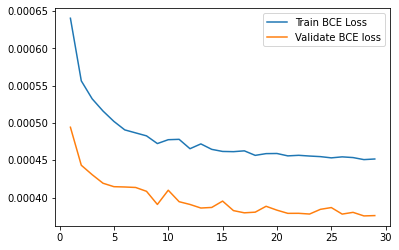

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,30),bce_dict_a['train'][1:],label='Train BCE Loss')
plt.plot(range(1,30),bce_dict_a['validate'][1:],label='Validate BCE loss')
plt.legend()

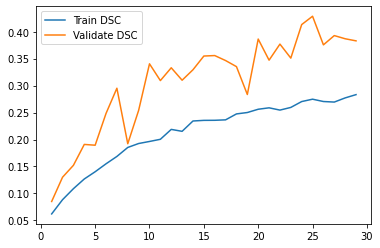

In [ ]:
plt.plot(range(1,30), dice_coeff_dict_a['train'][1:],label='Train DSC')
plt.plot(range(1,30), dice_coeff_dict_a['validate'][1:],label='Validate DSC')
plt.legend()

In [ ]:
model.eval()
sample = next(iter(dataloader['train']))
with torch.no_grad():
  output = torch.sigmoid(model(sample['x'].to(device)))

In [ ]:
def reverse_transform(inp):
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    return inp

## Unet

In [ ]:

import torch.optim as optim
import time
from torch.optim.lr_scheduler import StepLR
model = unet_2D().to(device)
#lambda_func = lambda epoch: 0.8 ** epoch
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = StepLR(optimizer, step_size=5 ,gamma=0.8)
model_u, loss_dict_u, dice_coeff_dict_u, bce_dict_u  = train_model(model, dataloader, optimizer, scheduler, num_epochs=30)

Epoch 0/29
----------
LR 0.01
train: bce: 0.051633, dice_coeff: 0.205996, loss: 0.422818
validate: bce: 0.000797, dice_coeff: 0.595178, loss: 0.202810
saving best model
0m 31s
Epoch 1/29
----------
LR 0.01
train: bce: 0.000777, dice_coeff: 0.331885, loss: 0.334446
validate: bce: 0.000465, dice_coeff: 0.381212, loss: 0.309626
0m 31s
Epoch 2/29
----------
LR 0.01
train: bce: 0.000533, dice_coeff: 0.261608, loss: 0.369462
validate: bce: 0.000448, dice_coeff: 0.218120, loss: 0.391164
0m 31s
Epoch 3/29
----------
LR 0.01
train: bce: 0.000560, dice_coeff: 0.302064, loss: 0.349248
validate: bce: 0.000432, dice_coeff: 0.437338, loss: 0.281547
0m 31s
Epoch 4/29
----------
LR 0.01
train: bce: 0.000500, dice_coeff: 0.268823, loss: 0.365839
validate: bce: 0.000409, dice_coeff: 0.322196, loss: 0.339107
0m 31s
Epoch 5/29
----------
LR 0.01
train: bce: 0.000502, dice_coeff: 0.291116, loss: 0.354693
validate: bce: 0.000409, dice_coeff: 0.443119, loss: 0.278645
0m 31s
Epoch 6/29
----------
LR 0.008
tra

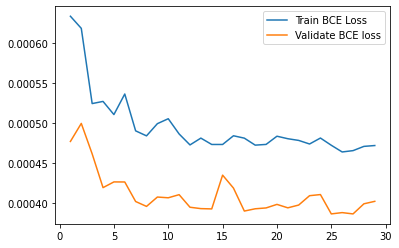

In [ ]:
plt.plot(range(1,30),bce_dict_u['train'][1:],label='Train BCE Loss')
plt.plot(range(1,30),bce_dict_u['validate'][1:],label='Validate BCE loss')
plt.legend()

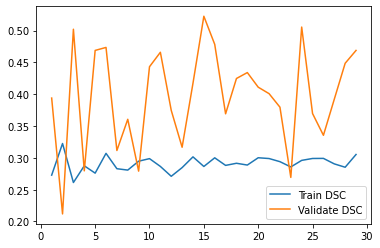

In [ ]:
plt.plot(range(1,30), dice_coeff_dict_u['train'][1:],label='Train DSC')
plt.plot(range(1,30), dice_coeff_dict_u['validate'][1:],label='Validate DSC')
plt.legend()

## Unet multires

In [ ]:
import torch.optim as optim
import time
from torch.optim.lr_scheduler import StepLR, MultiStepLR
model = MultiResNet().to(device)
#lambda_func = lambda epoch: epoch**0.5  
#scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.2)
optimizer = optim.Adam(model.parameters(), lr = 0.05)
scheduler = MultiStepLR(optimizer, milestones=[3,10,15,25], gamma=0.5)
model_r, loo_dict_r, dice_dict_r, bce_dict_r = train_model(model, dataloader, optimizer, scheduler, num_epochs=30)

Epoch 0/29
----------
LR 0.05
train: bce: 0.041796, dice_coeff: 0.393279, loss: 0.324258
validate: bce: 0.000687, dice_coeff: 0.612086, loss: 0.194300
saving best model
0m 53s
Epoch 1/29
----------
LR 0.05
train: bce: 0.000605, dice_coeff: 0.355626, loss: 0.322490
validate: bce: 0.000416, dice_coeff: 0.326427, loss: 0.336994
0m 53s
Epoch 2/29
----------
LR 0.05
train: bce: 0.000509, dice_coeff: 0.280858, loss: 0.359825
validate: bce: 0.000845, dice_coeff: 0.276790, loss: 0.362027
0m 53s
Epoch 3/29
----------
LR 0.05
train: bce: 0.000497, dice_coeff: 0.275348, loss: 0.362575
validate: bce: 0.000473, dice_coeff: 0.312470, loss: 0.344001
0m 52s
Epoch 4/29
----------
LR 0.025
train: bce: 0.000487, dice_coeff: 0.264515, loss: 0.367986
validate: bce: 0.000428, dice_coeff: 0.324047, loss: 0.338191
0m 53s
Epoch 5/29
----------
LR 0.025
train: bce: 0.000481, dice_coeff: 0.277448, loss: 0.361516
validate: bce: 0.000463, dice_coeff: 0.123890, loss: 0.438287
0m 53s
Epoch 6/29
----------
LR 0.025
t

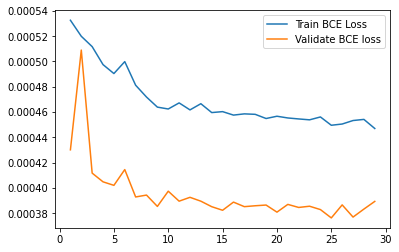

In [ ]:
plt.plot(range(1,30),bce_dict_r['train'][1:],label='Train BCE Loss')
plt.plot(range(1,30),bce_dict_r['validate'][1:],label='Validate BCE loss')
plt.legend()

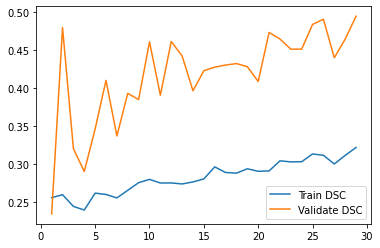

In [ ]:
plt.plot(range(1,30), dice_dict_r['train'][1:],label='Train DSC')
plt.plot(range(1,30), dice_dict_r['validate'][1:],label='Validate DSC')
plt.legend()

In [ ]:

model.eval()
sample = next(iter(dataloader['train']))
with torch.no_grad():
  output = torch.sigmoid(model(sample['x'].to(device)))
sample_img = sample['x'].squeeze().numpy()
for img in sample_img:
  plt.figure()
  plt.imshow(img, cmap = 'gray')
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
output = output.cpu().squeeze().numpy()
for img in output:
  #img = np.where(img > 0.5, 1, 0)
  plt.figure()
  plt.imshow(img, cmap = 'gray')
  plt.show()

In [ ]:
for img in sample['y']:
  img = img.squeeze().numpy()
  plt.figure()
  plt.imshow(img, cmap = 'gray')
  plt.show()

# Model compare

## Unet

In [ ]:
i = 0
for img in dataloader_test['validate']:
  if i == 10:
    break
  mask = img['y'].squeeze().numpy()
  origin = img['x'].squeeze().numpy()
  with torch.no_grad():
    output = torch.sigmoid(model_u(img['x'].to(device)))
    output = output.cpu().squeeze().numpy()
  for i in range(len(mask)):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,20))
    ax1.imshow(origin[i], cmap='gray')
    ax2.imshow(mask[i], cmap = 'gray')
    ax3.imshow(output[i], cmap= 'gray')
    plt.show()

## Multires

In [ ]:

import matplotlib.pyplot as plt
i = 0
for img in dataloader_test['validate']:
  if i == 10:
    break
  mask = img['y'].squeeze().numpy()
  origin = img['x'].squeeze().numpy()
  with torch.no_grad():
    output = torch.sigmoid(model_r(img['x'].to(device)))
    output = output.cpu().squeeze().numpy()
  for i in range(len(mask)):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,20))
    ax1.imshow(origin[i], cmap='gray')
    ax2.imshow(mask[i], cmap = 'gray')
    ax3.imshow(output[i], cmap= 'gray')
    plt.show()

## attention

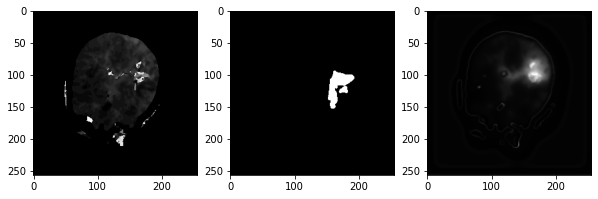

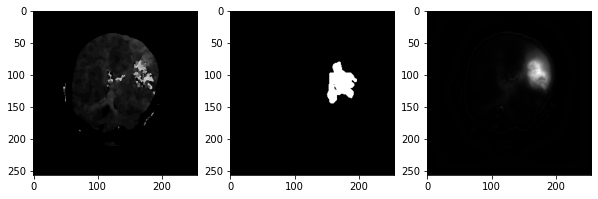

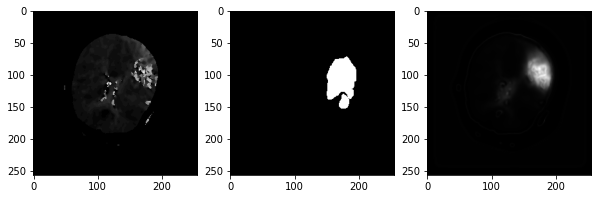

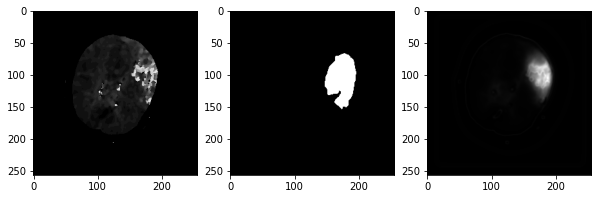

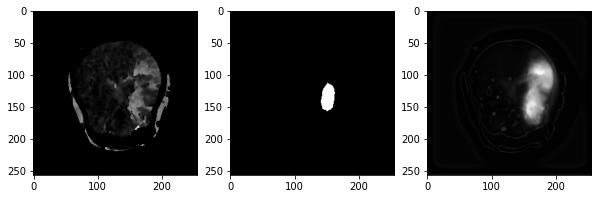

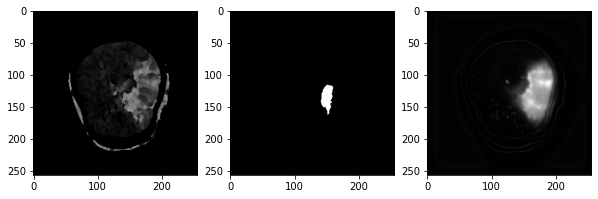

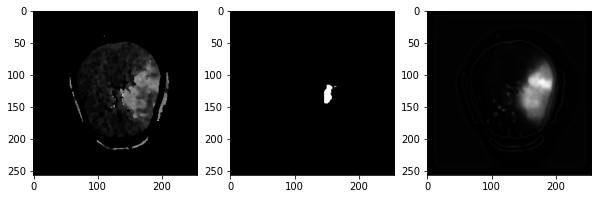

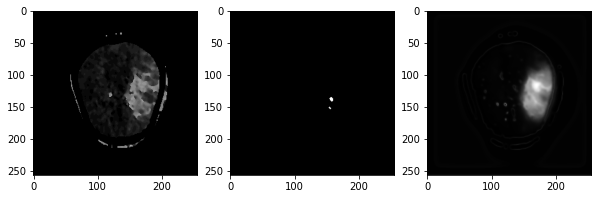

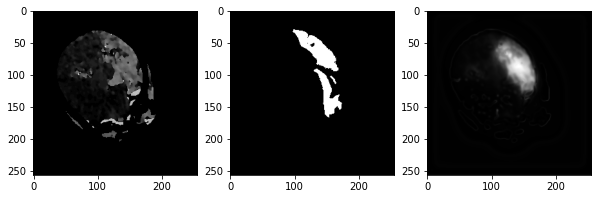

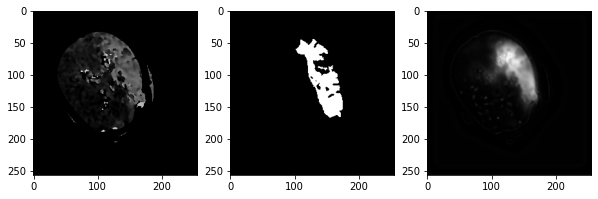

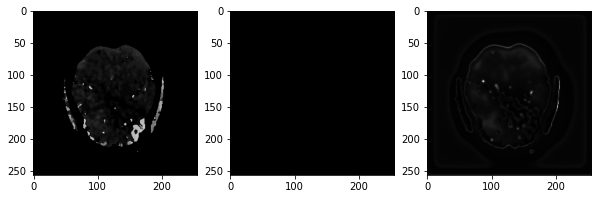

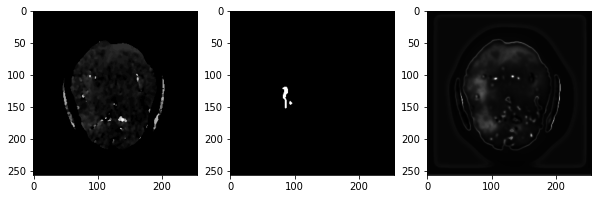

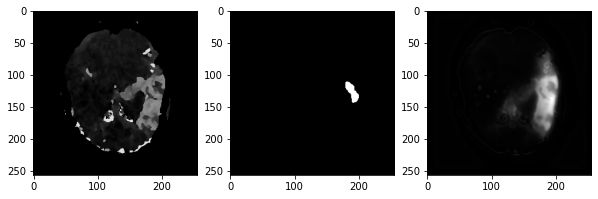

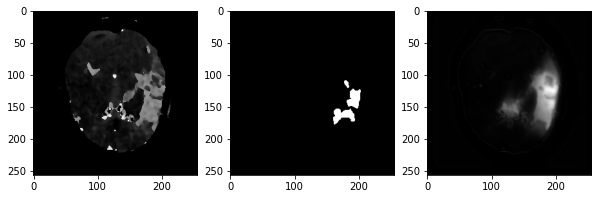

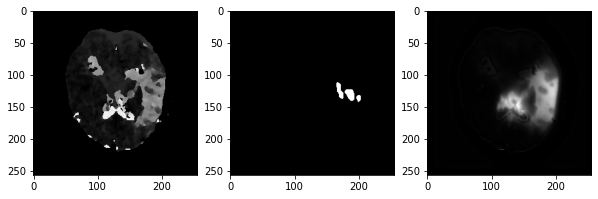

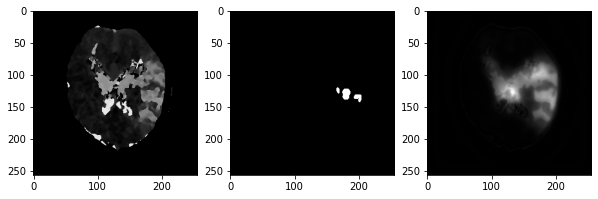

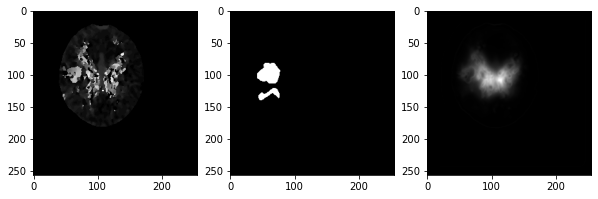

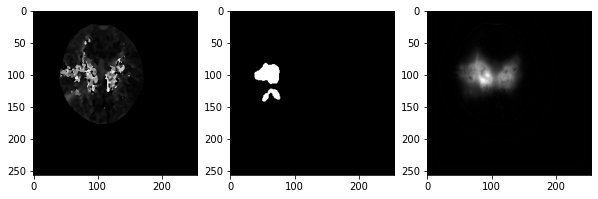

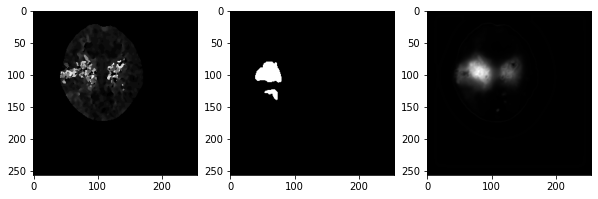

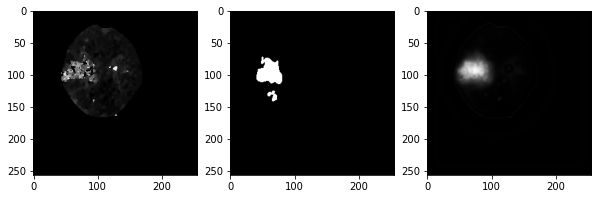

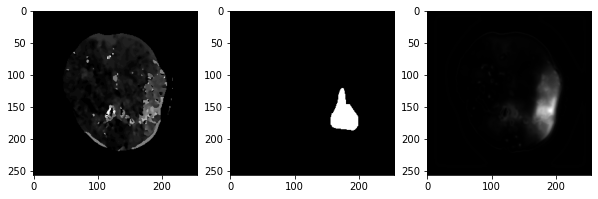

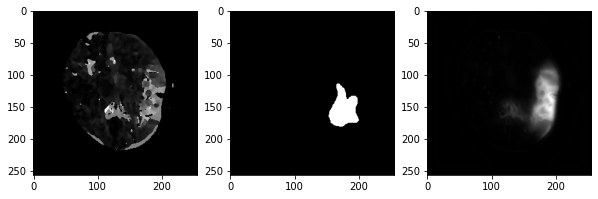

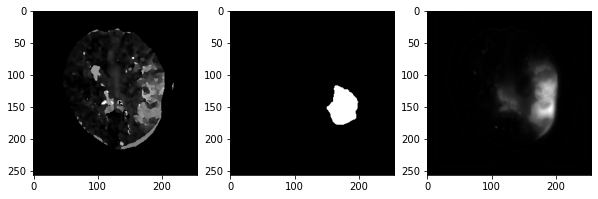

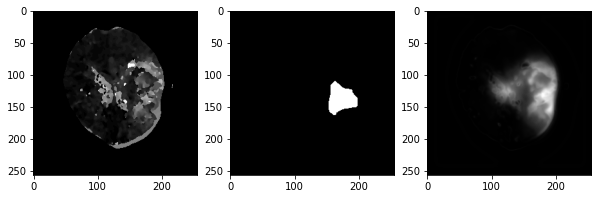

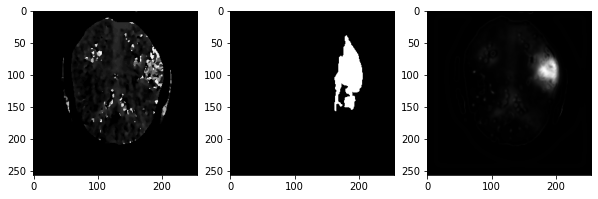

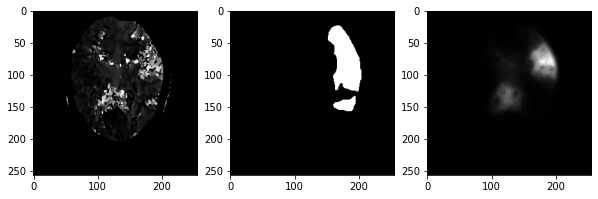

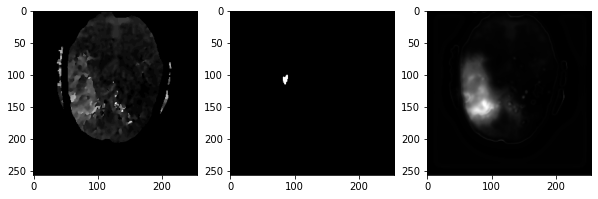

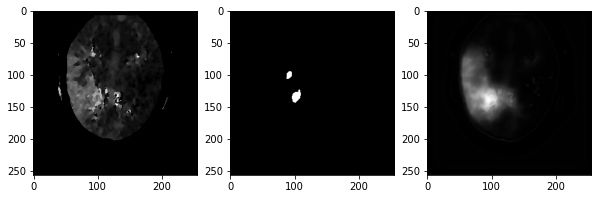

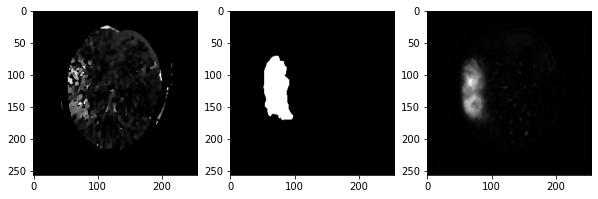

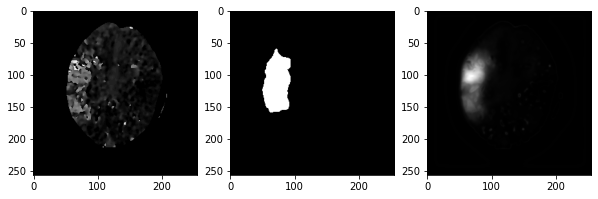

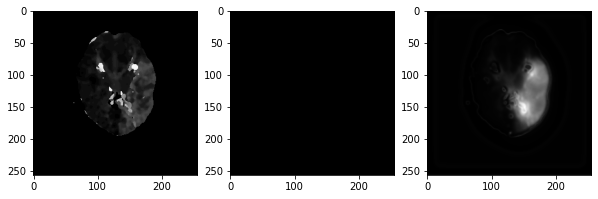

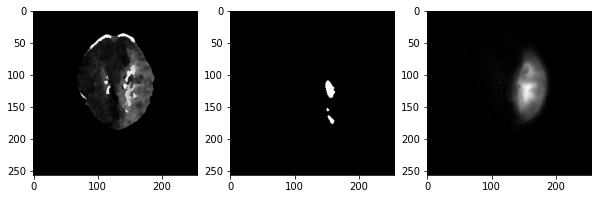

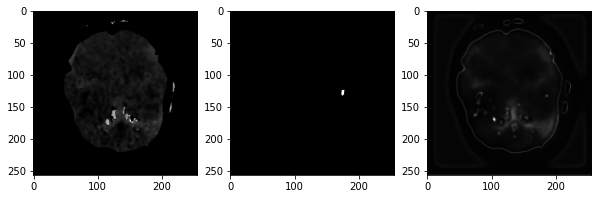

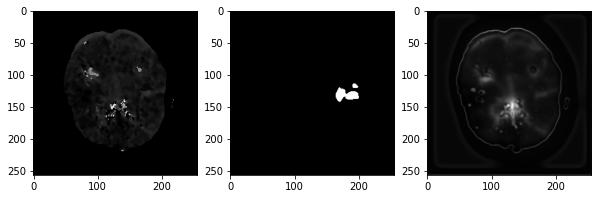

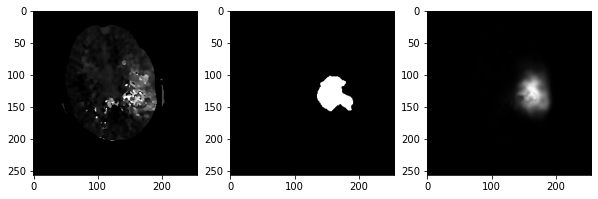

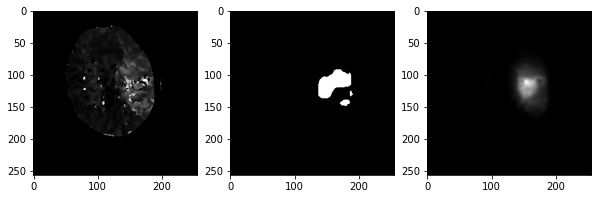

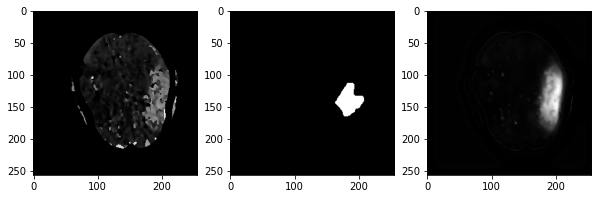

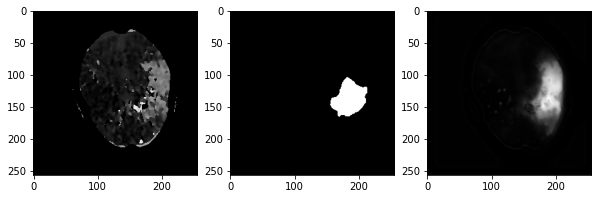

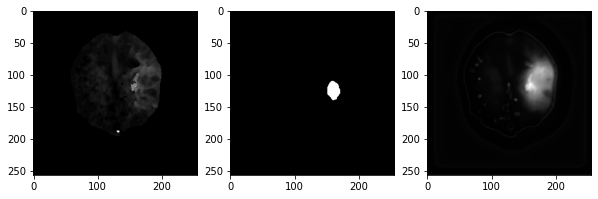

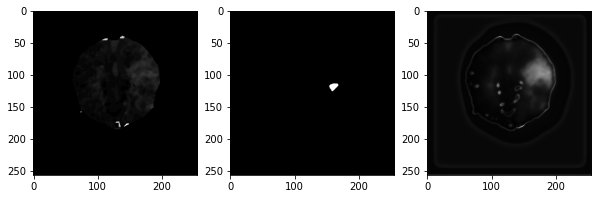

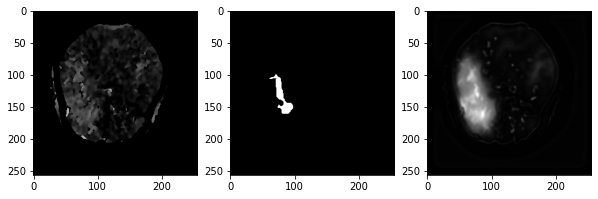

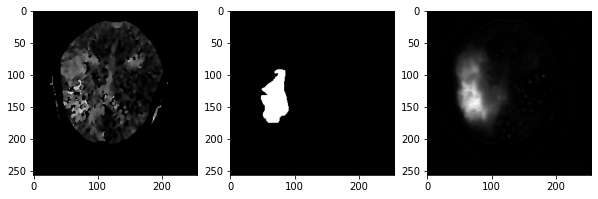

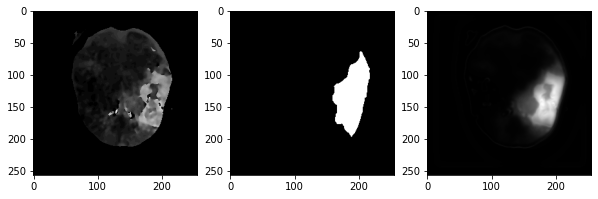

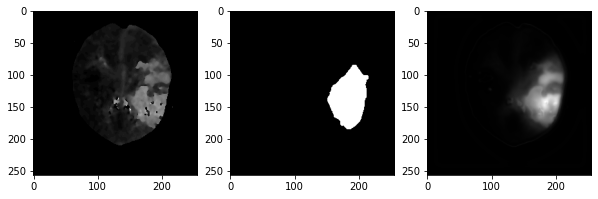

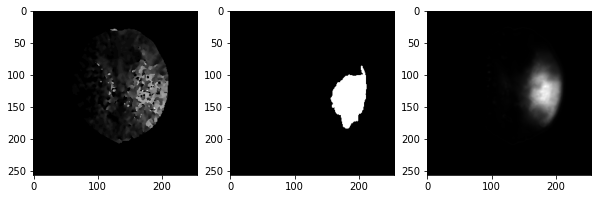

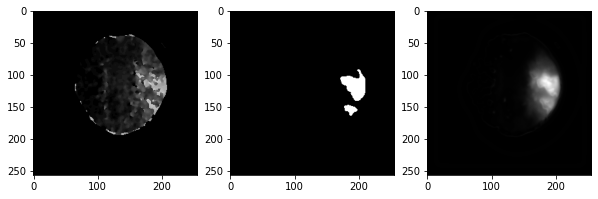

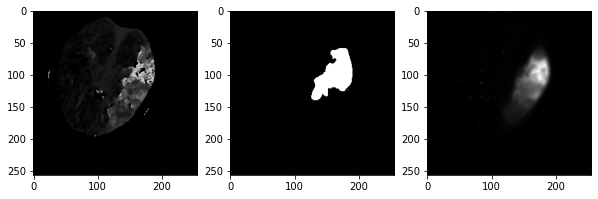

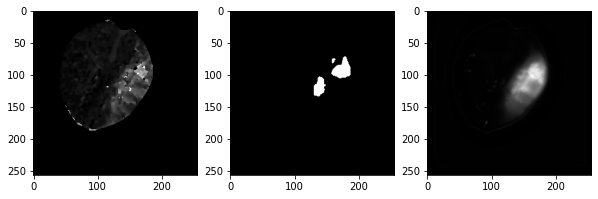

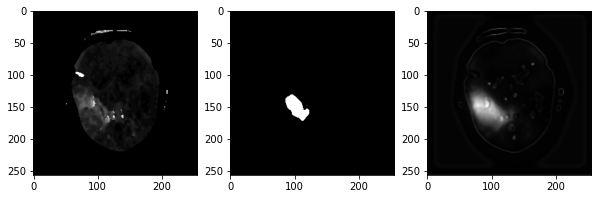

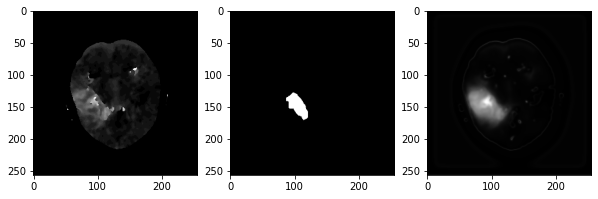

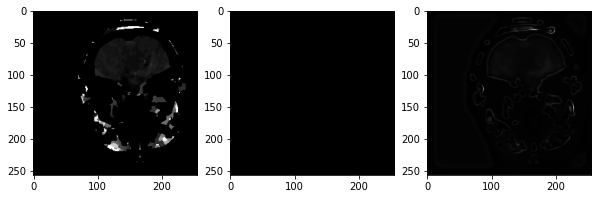

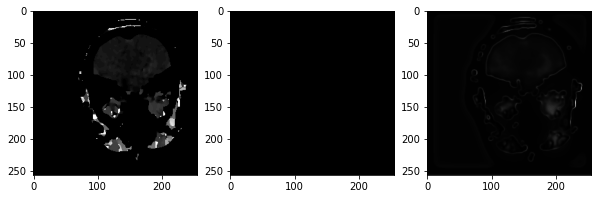

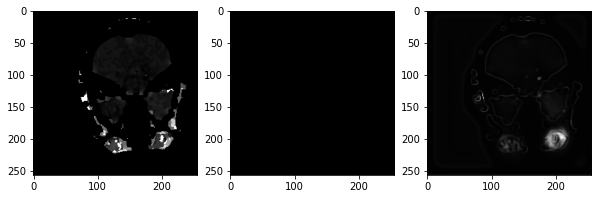

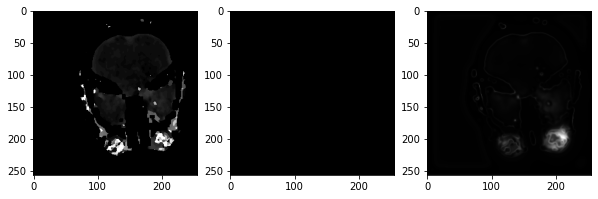

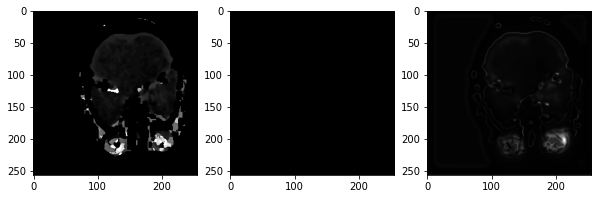

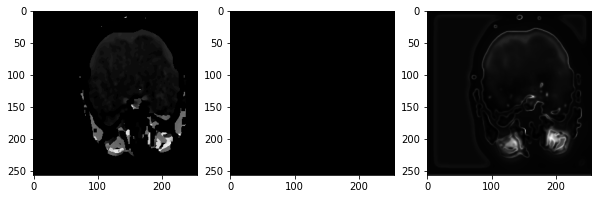

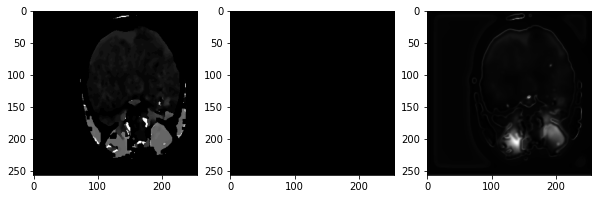

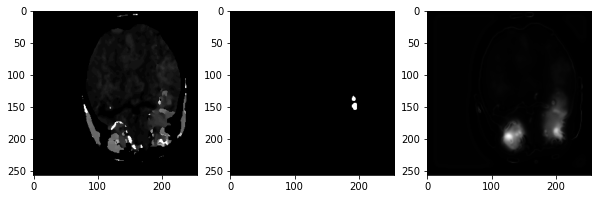

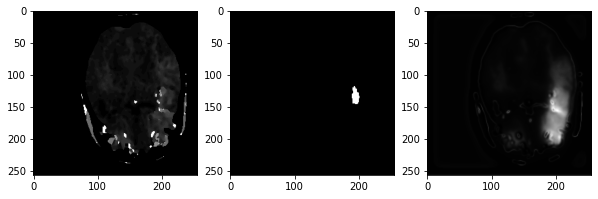

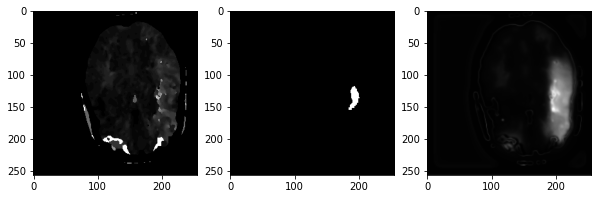

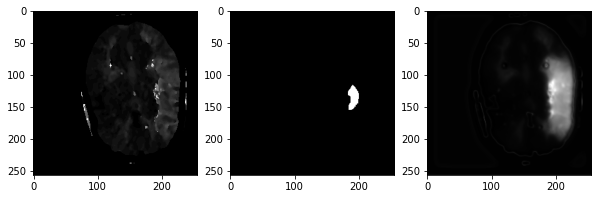

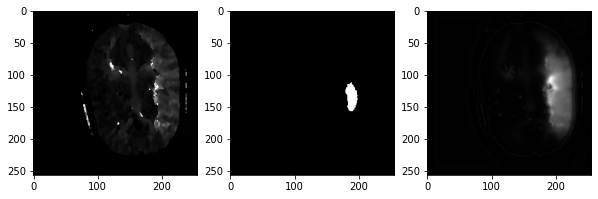

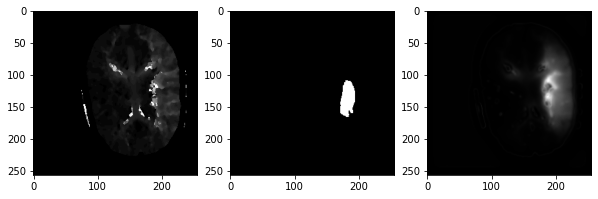

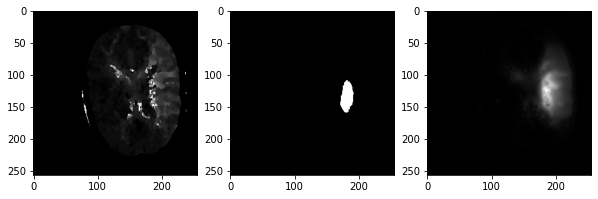

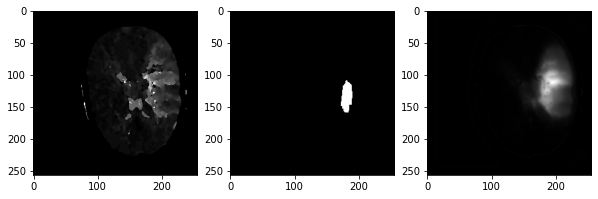

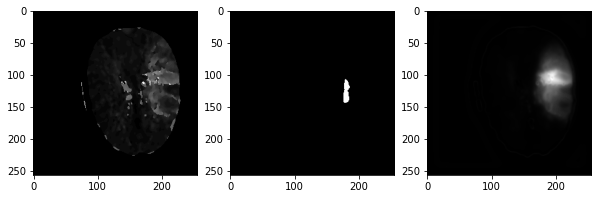

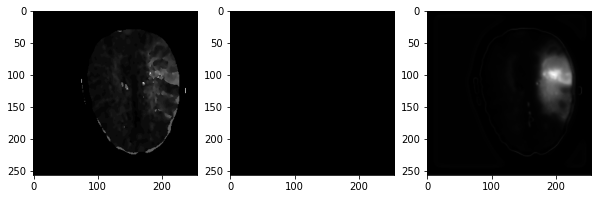

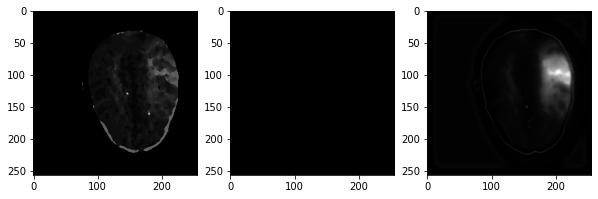

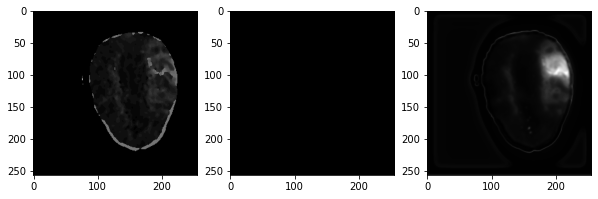

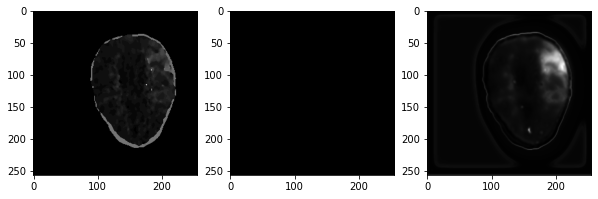

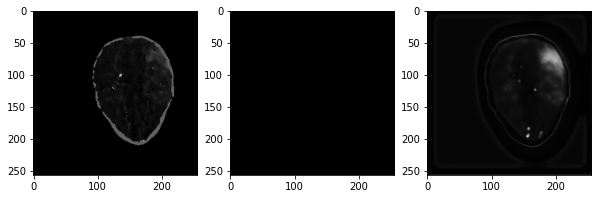

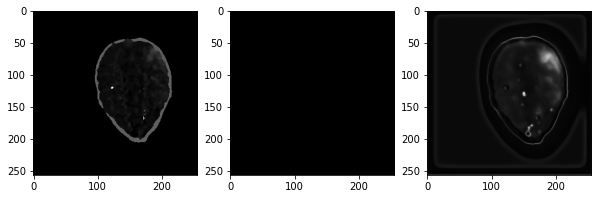

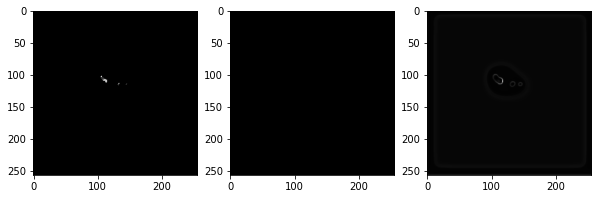

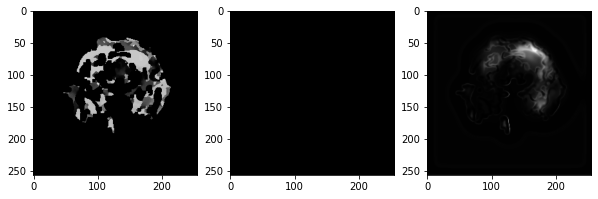

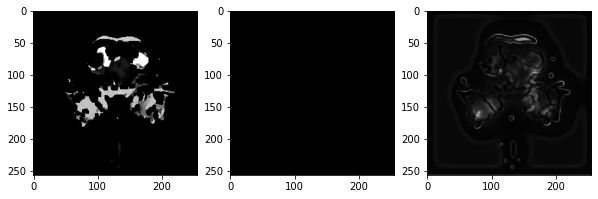

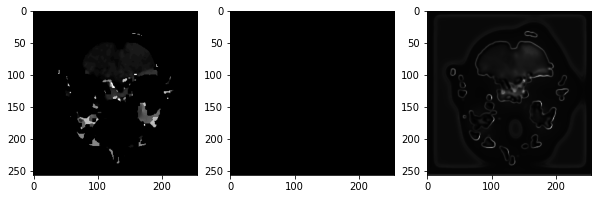

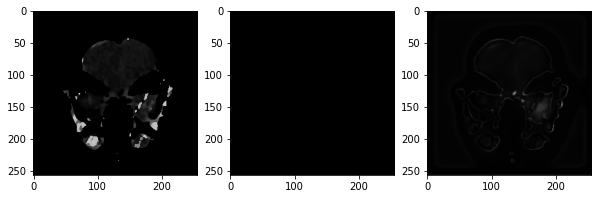

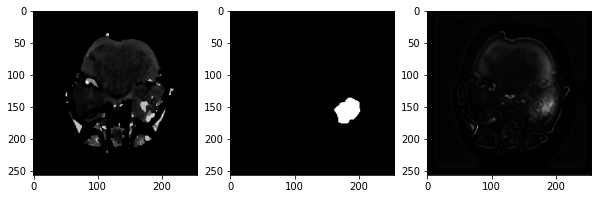

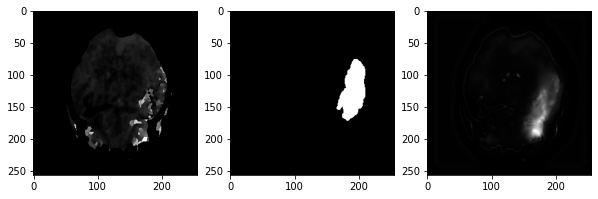

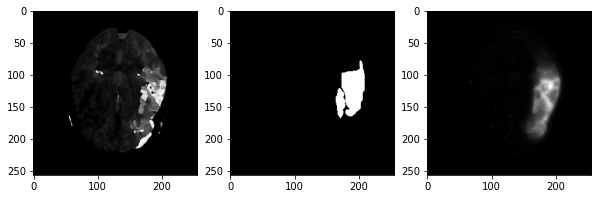

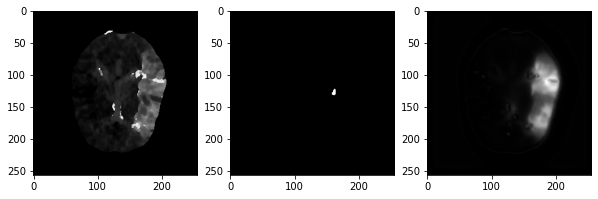

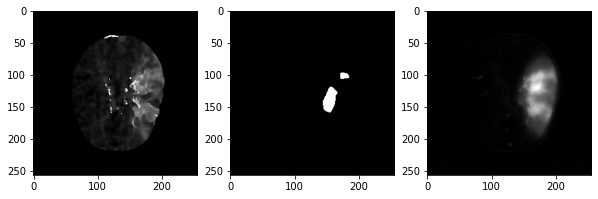

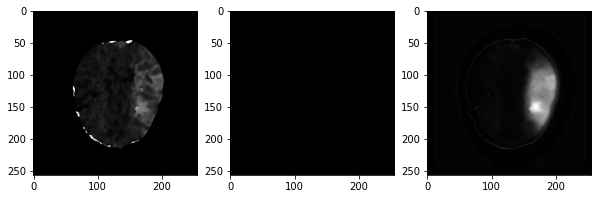

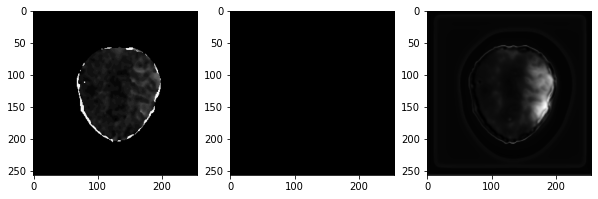

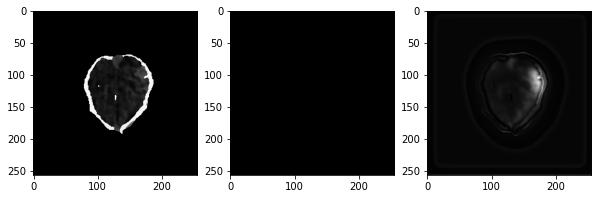

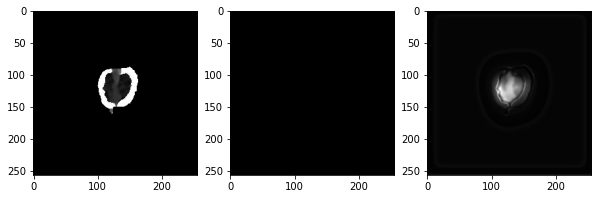

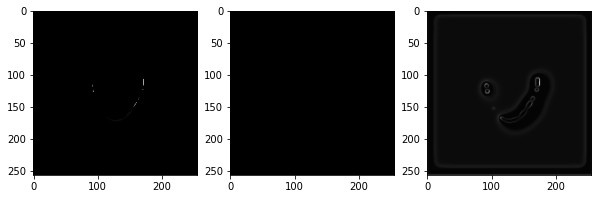

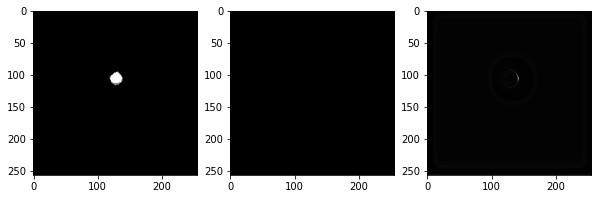

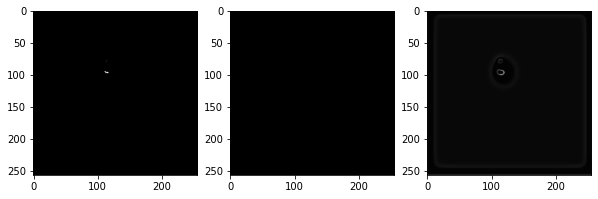

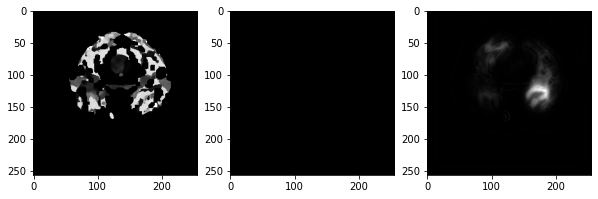

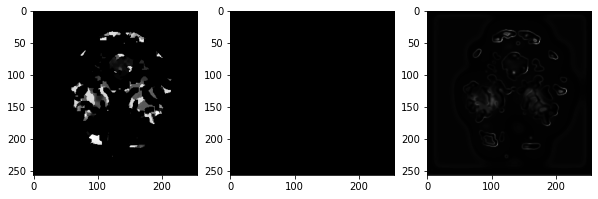

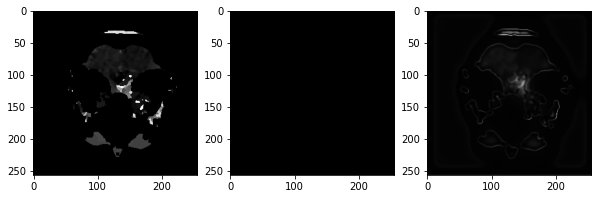

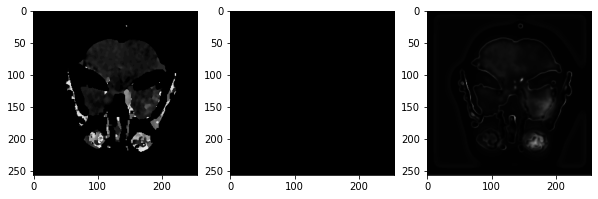

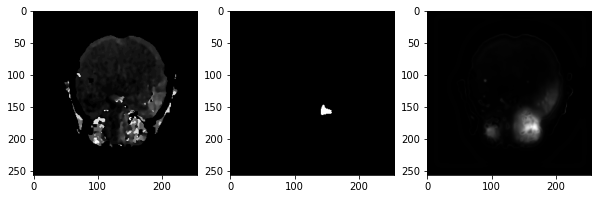

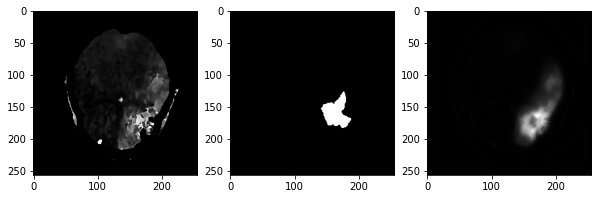

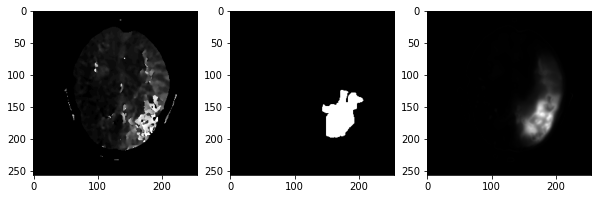

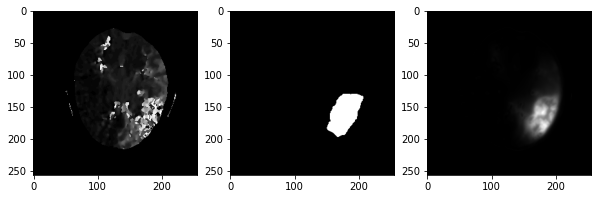

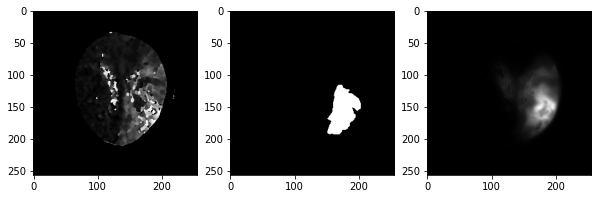

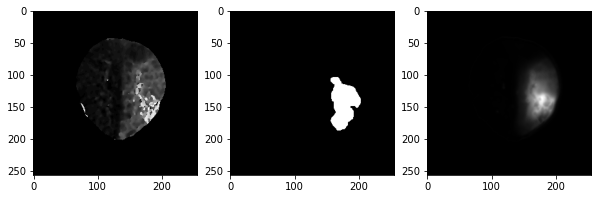

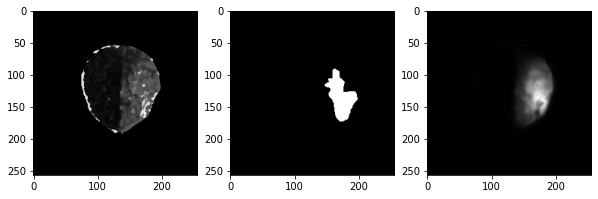

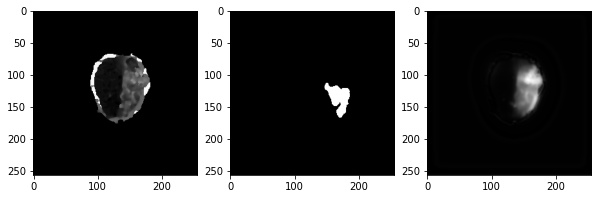

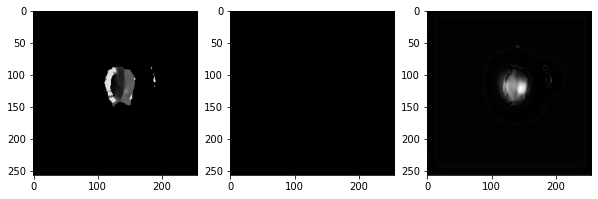

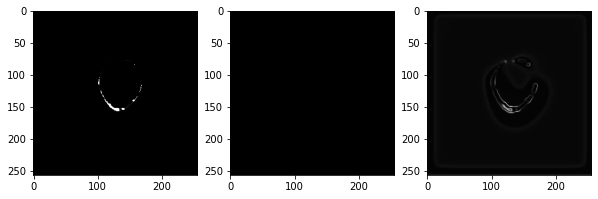

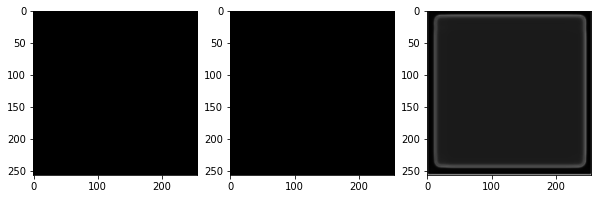

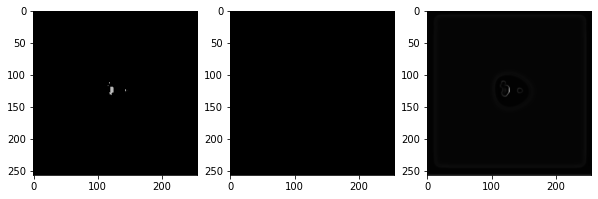

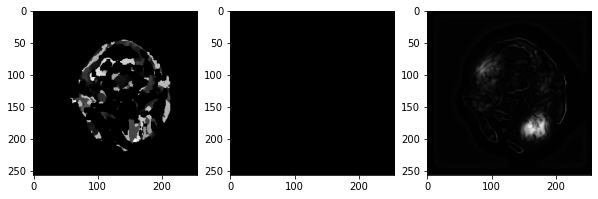

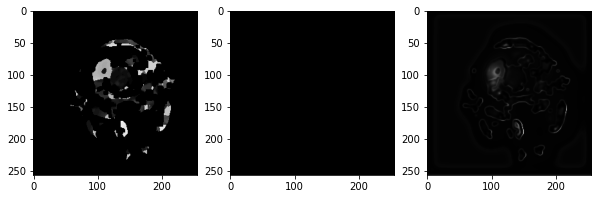

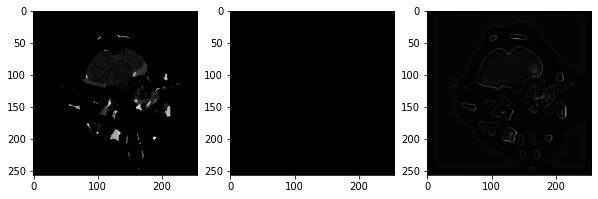

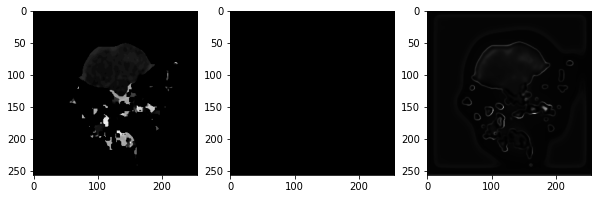

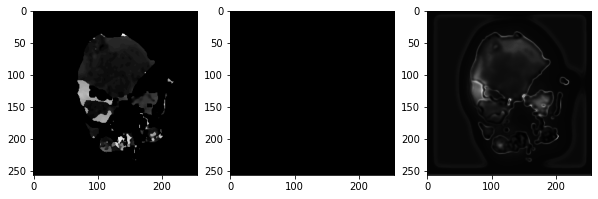

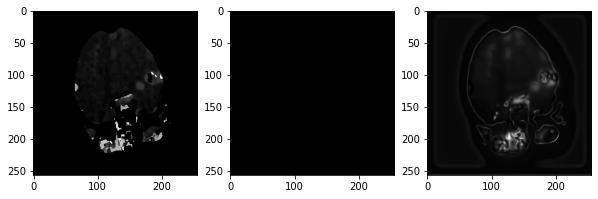

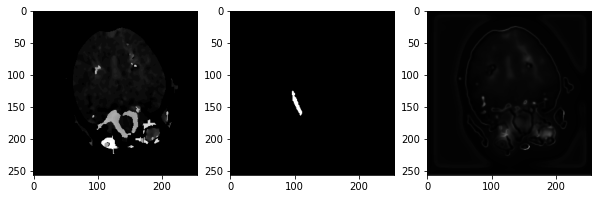

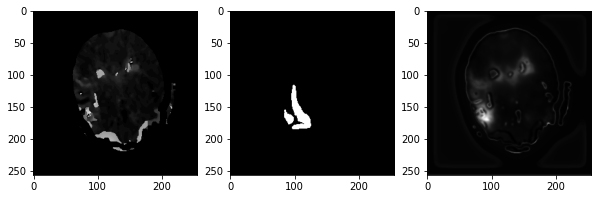

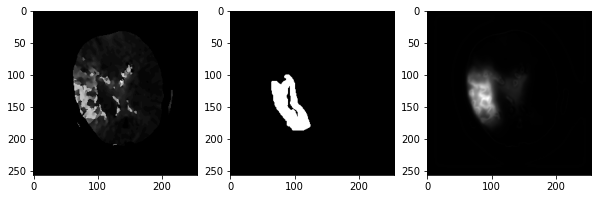

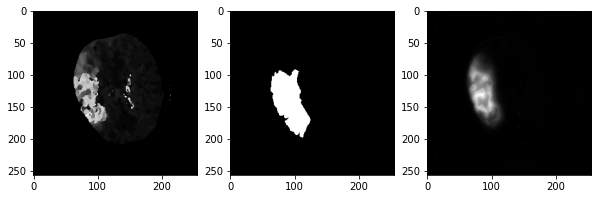

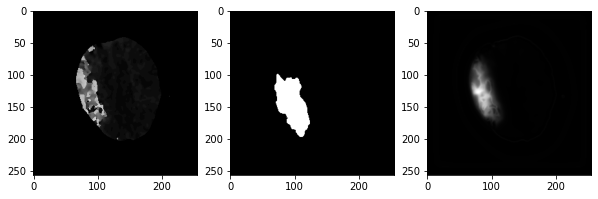

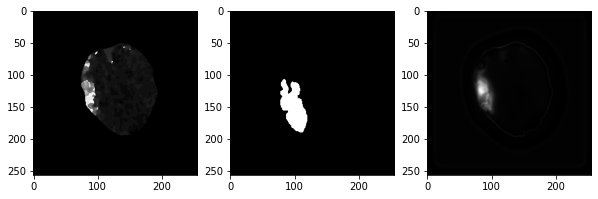

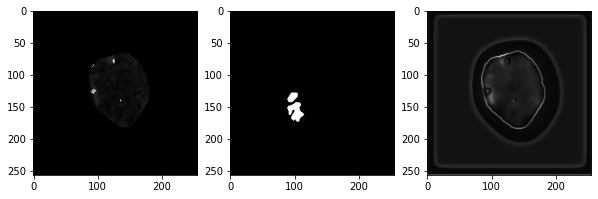

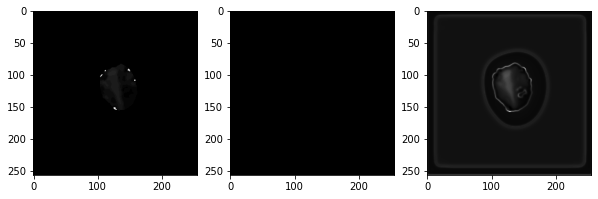

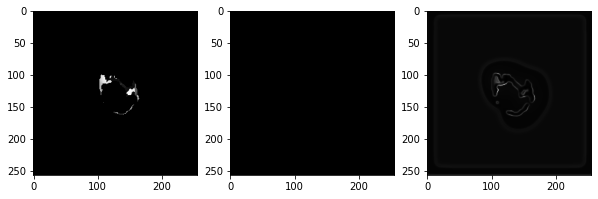

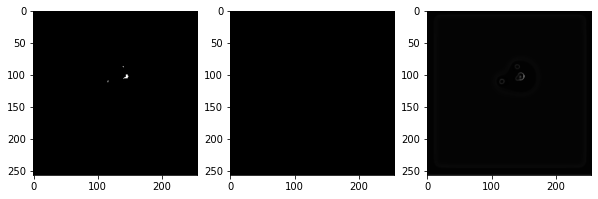

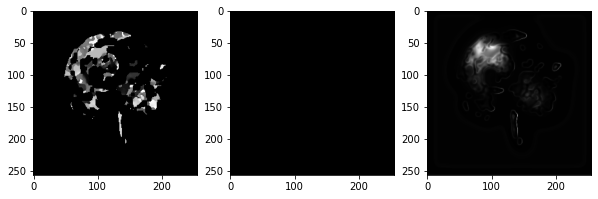

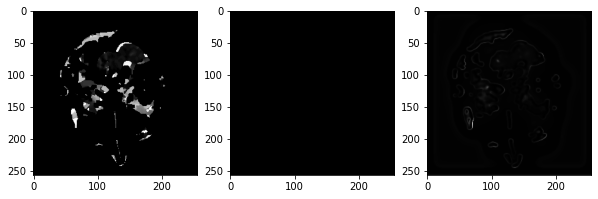

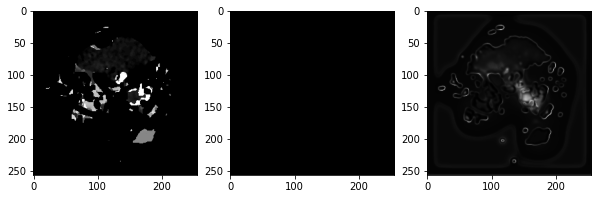

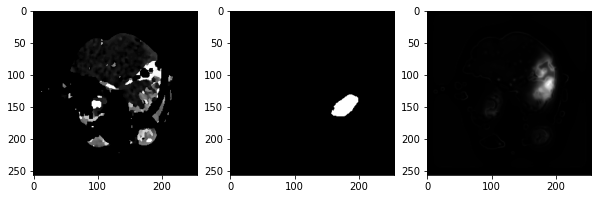

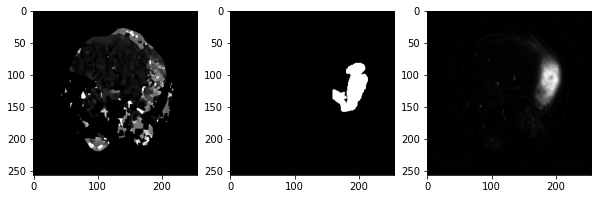

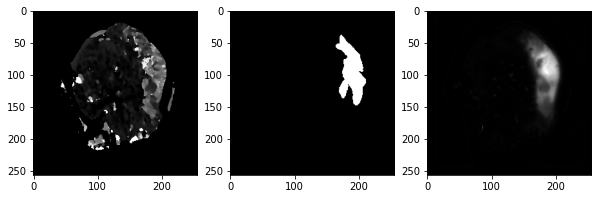

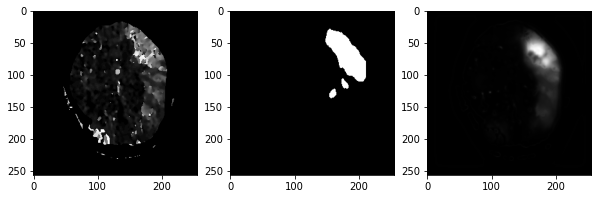

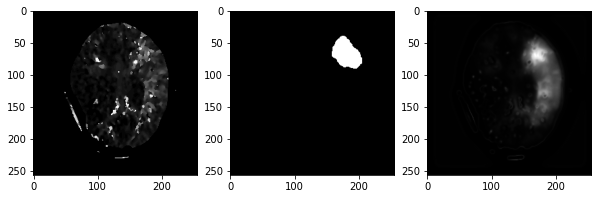

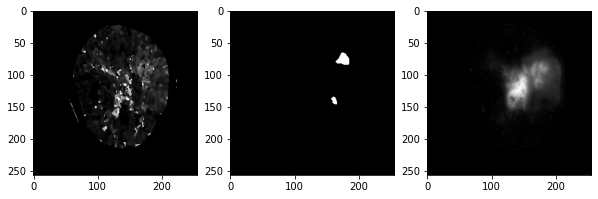

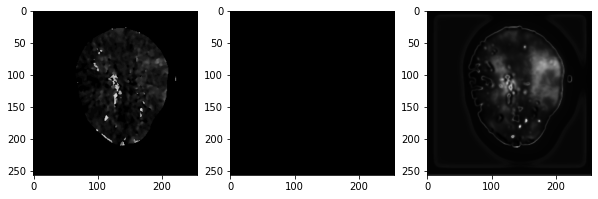

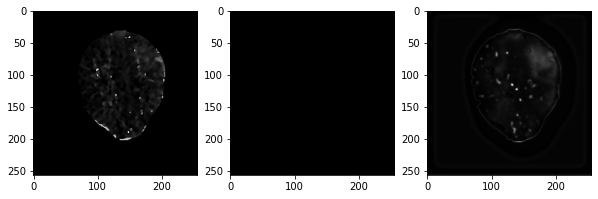

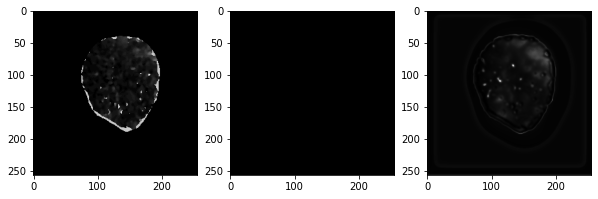

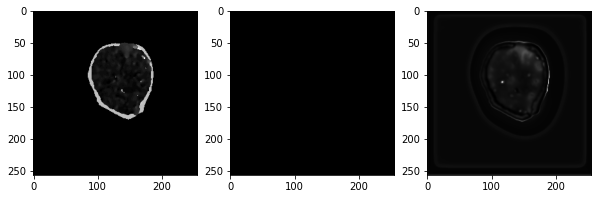

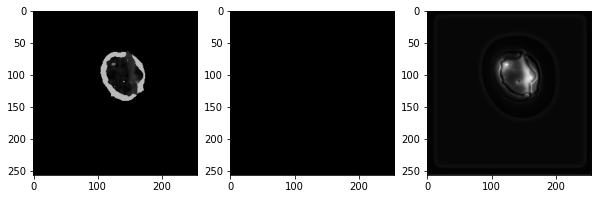

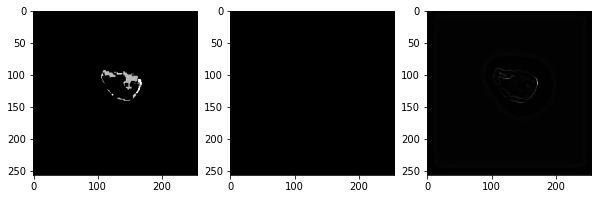

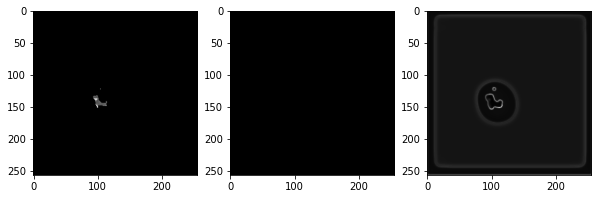

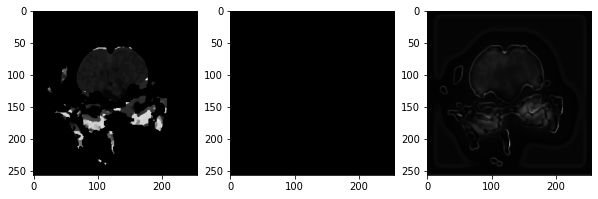

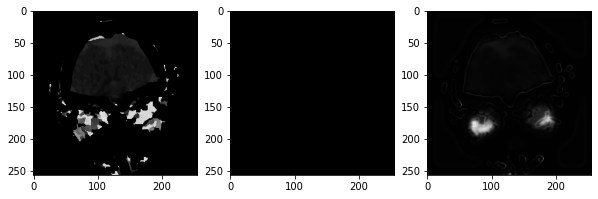

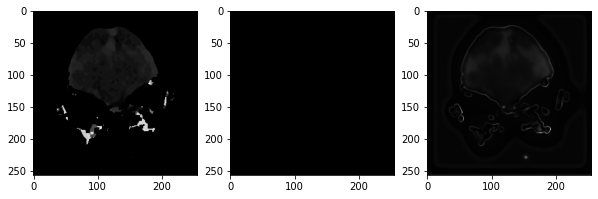

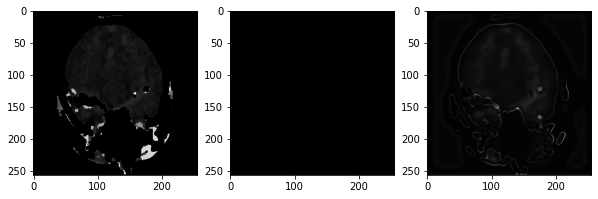

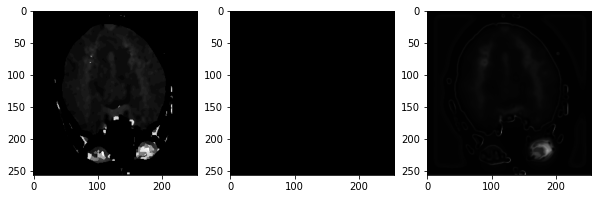

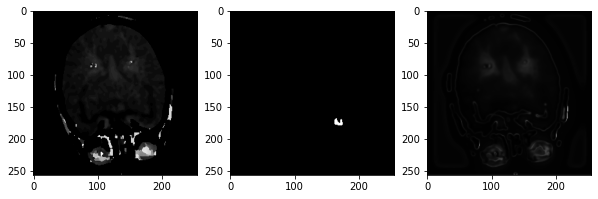

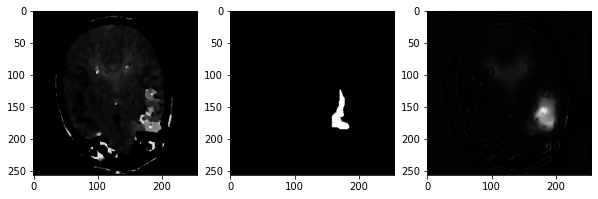

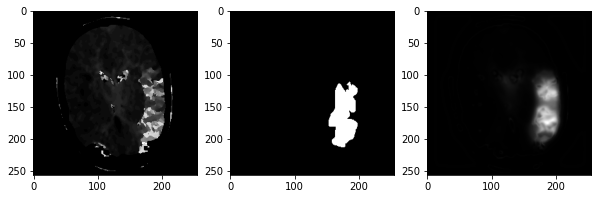

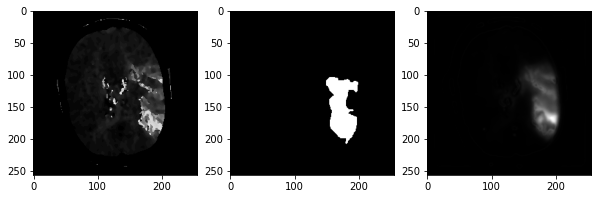

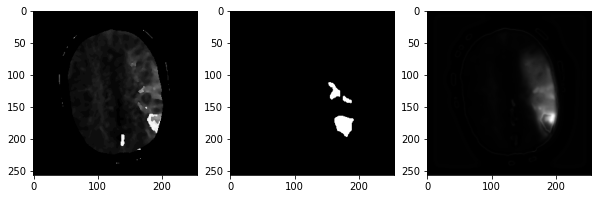

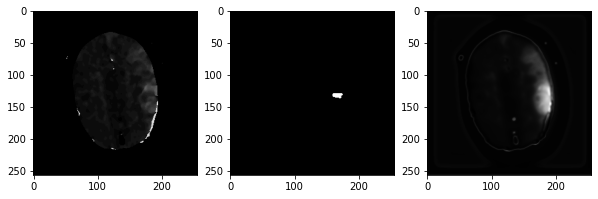

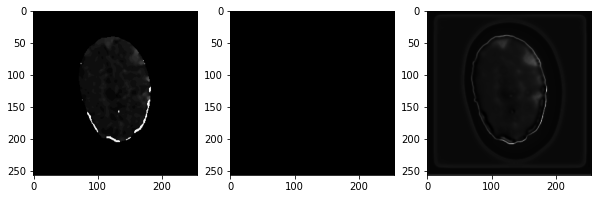

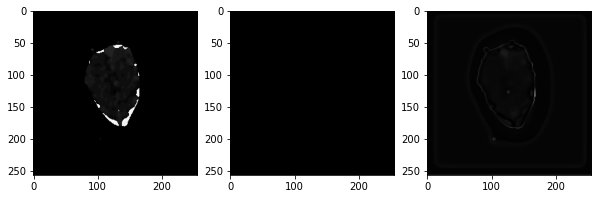

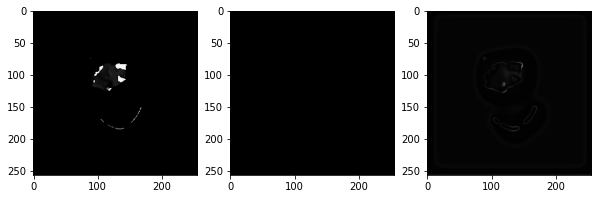

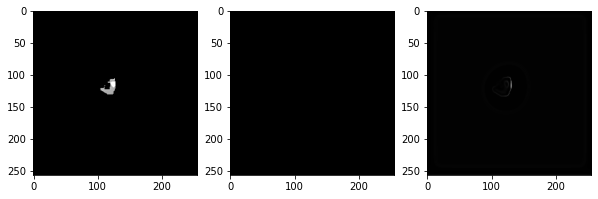

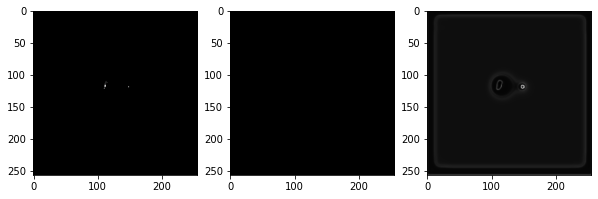

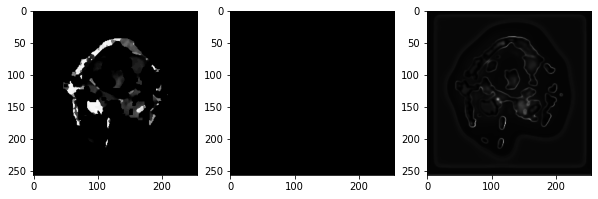

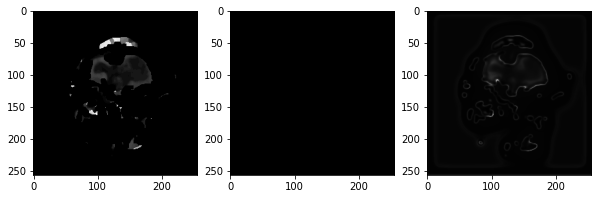

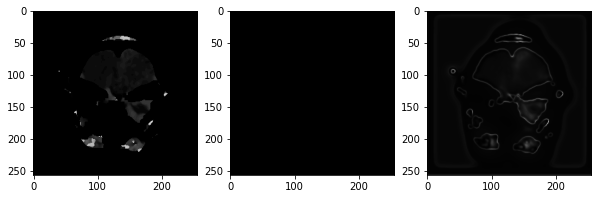

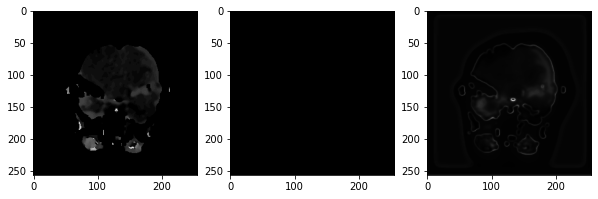

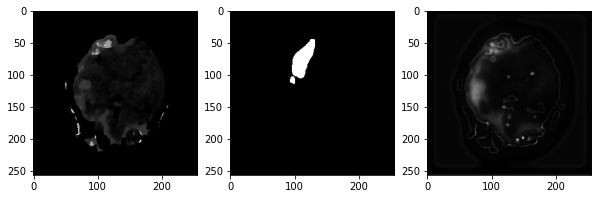

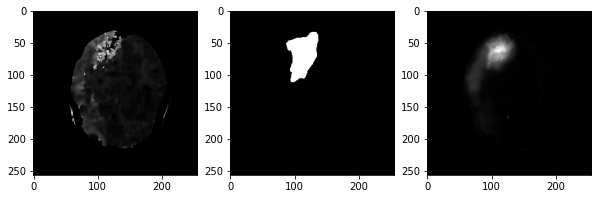

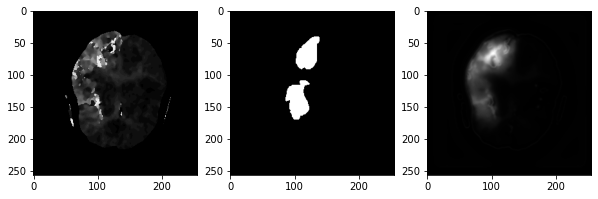

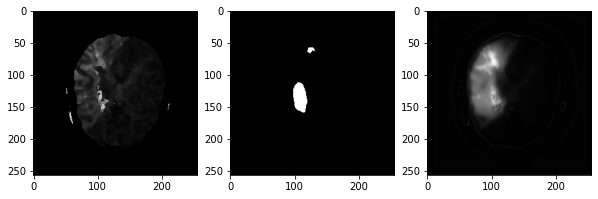

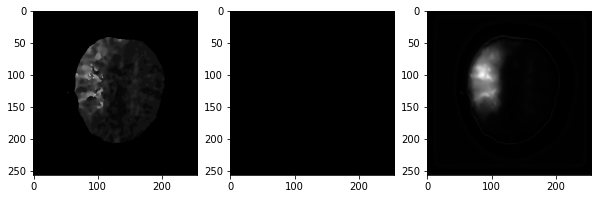

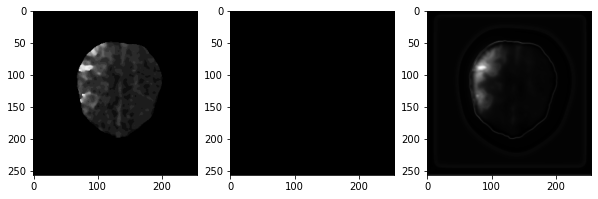

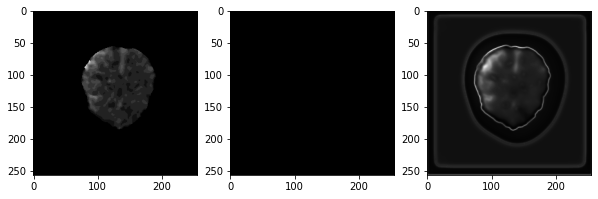

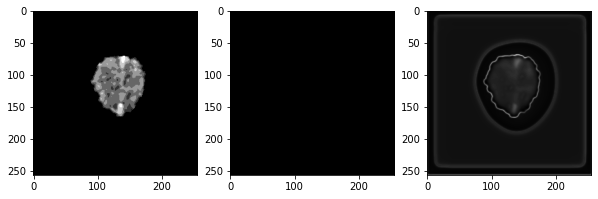

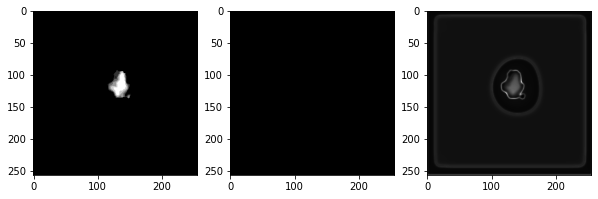

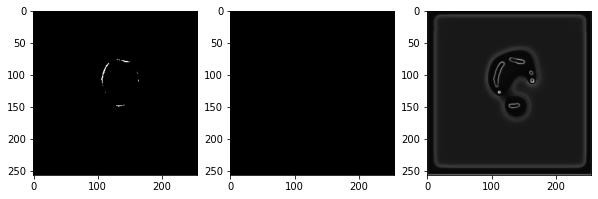

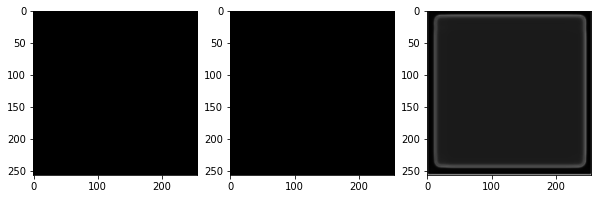

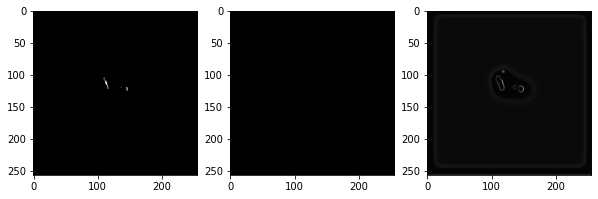

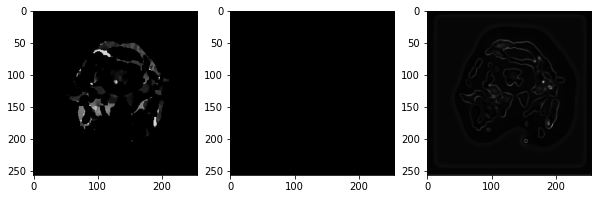

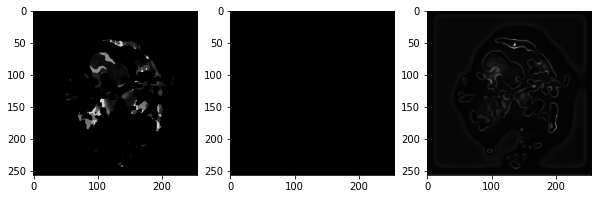

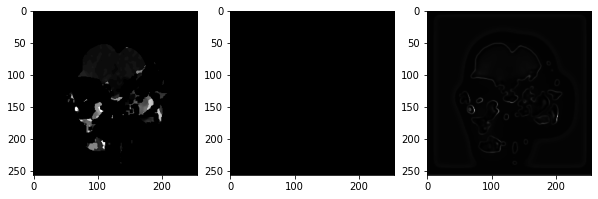

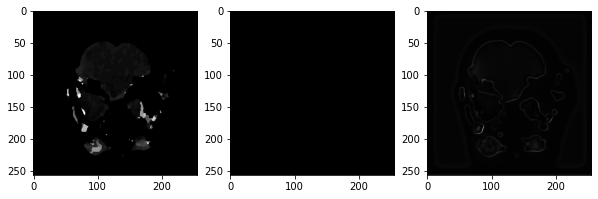

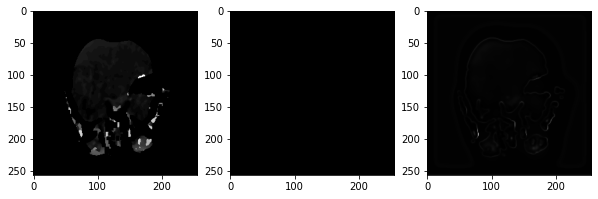

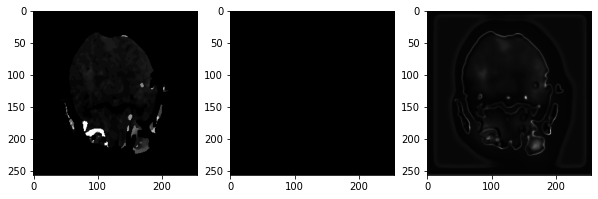

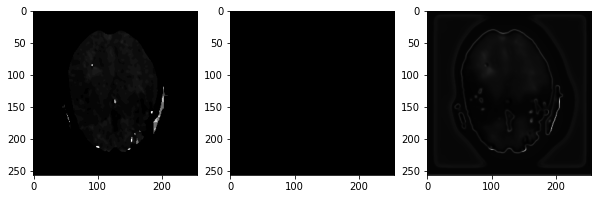

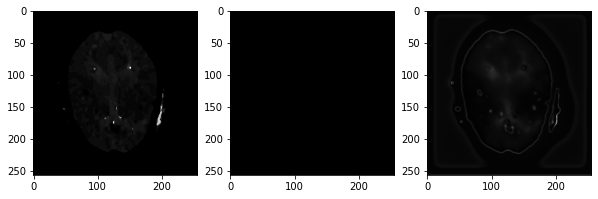

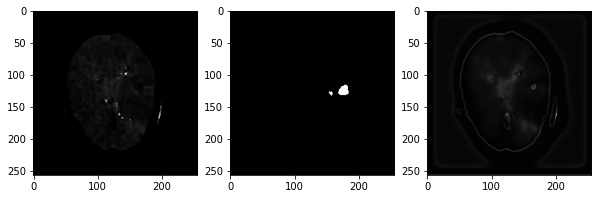

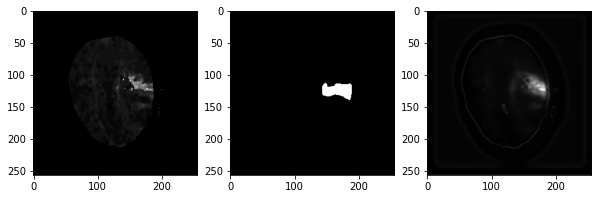

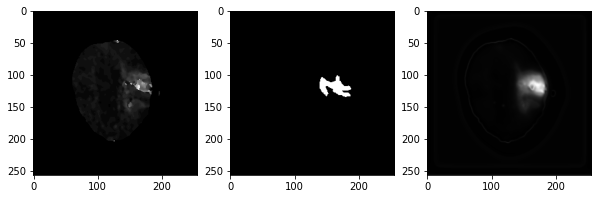

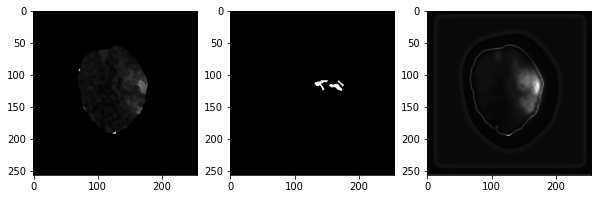

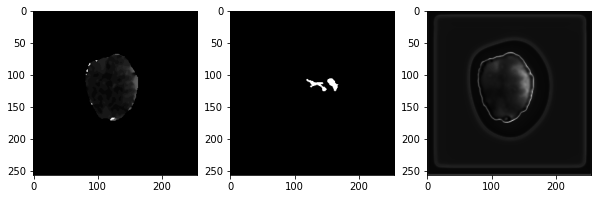

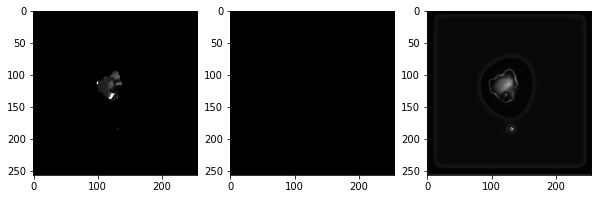

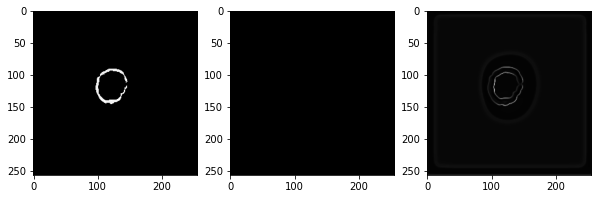

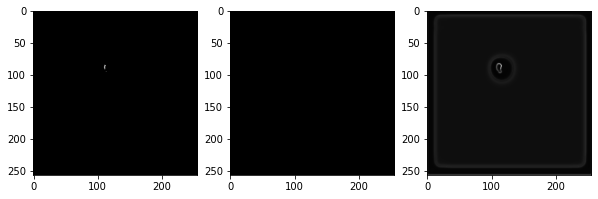

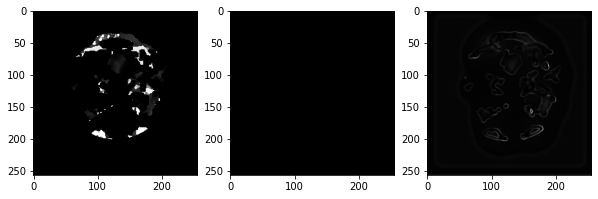

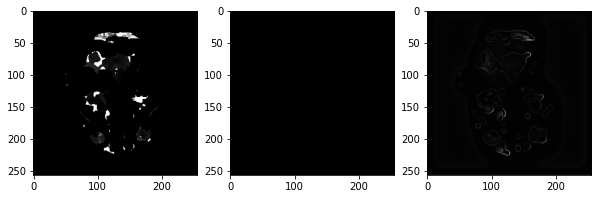

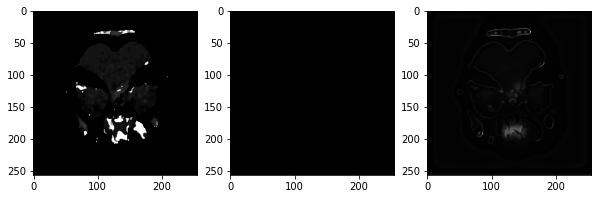

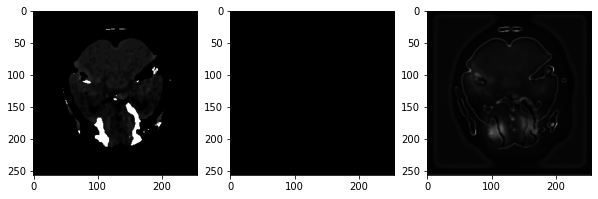

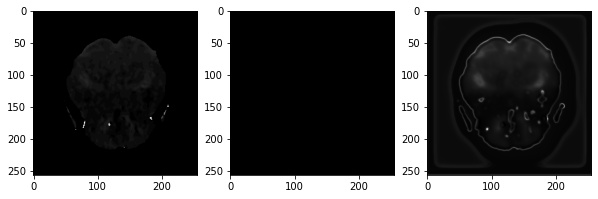

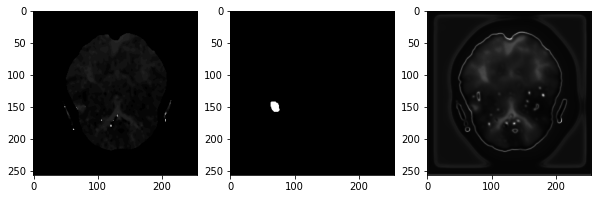

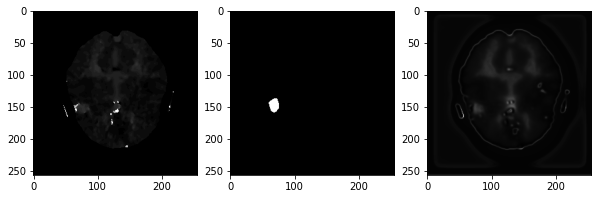

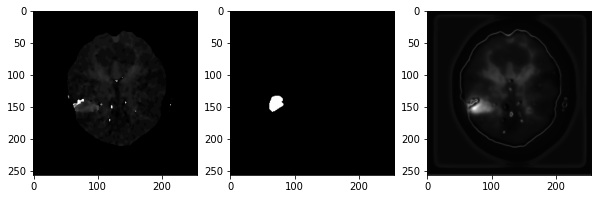

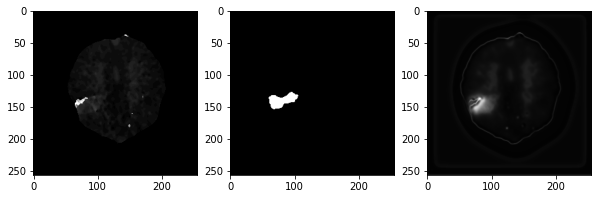

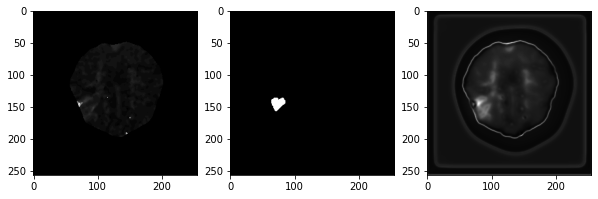

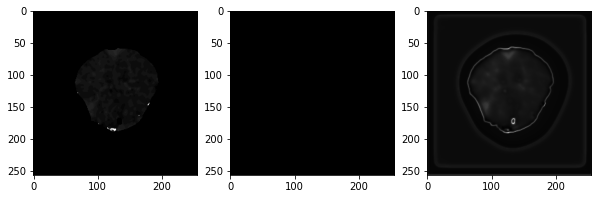

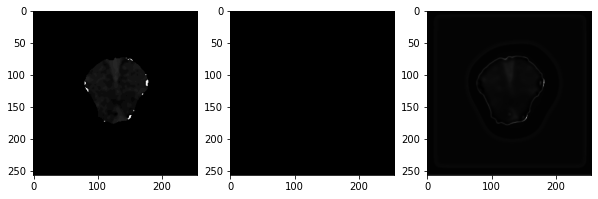

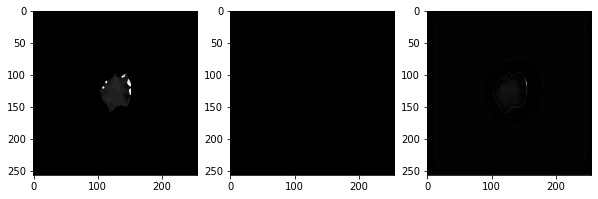

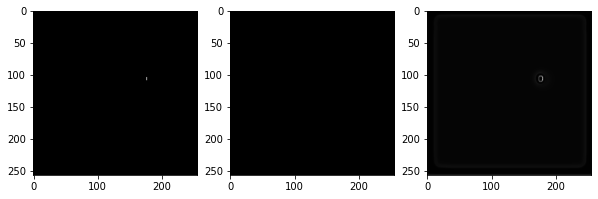

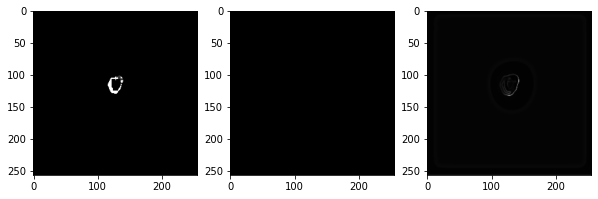

In [ ]:
import matplotlib.pyplot as plt
i = 0
for img in dataloader_test['validate']:
  if i == 10:
    break
  mask = img['y'].squeeze().numpy()
  origin = img['x'].squeeze().numpy()
  with torch.no_grad():
    output = torch.sigmoid(model_a(img['x'].to(device)))
    output = output.cpu().squeeze().numpy()
  for i in range(len(mask)):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,20))
    ax1.imshow(origin[i], cmap='gray')
    ax2.imshow(mask[i], cmap = 'gray')
    ax3.imshow(output[i], cmap= 'gray')
    plt.show()
  i+=1

# Five Fold Cross Validation

Data were organized into

train_1.csv
validate_1.csv

train_2.csv
validate_2.csv

train_3.csv
validate_3.csv

train_4.csv
validate_4.csv

train_5.csv
validate_5.csv

Five fold cross validation was computed by training on each training set and evaluated on each validation. Then the average validation dice was computed

In [ ]:
# code to plot validation result bar graph
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Unet2d', 'Attention Unet', 'Multi-Res Unet')
y_pos = np.arange(len(objects))
performance = [UCmean, ACmean, RCmean]

plt.bar(y_pos, performance, align='center', alpha=0.5, color = "g", width = 0.5)
plt.xticks(y_pos, objects)
plt.ylim(0.3,0.5)
plt.ylabel('Dice Similarity Coefficient')
plt.title('Cross-Validation Results')

plt.show()

#Dataloaders to merge five channels

In [ ]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import torch
import nibabel as nib
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
import random

train_transform_toinput = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])

class BrainCTDataset_train(Dataset):

    def __init__(self, csv_file, root_dir, transform2 = None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform2 = transform2

    def __len__(self):
        return len(self.data_frame)
    
    def transform(self, image1,image2,image3,image4,image5, mask):
        # Resize
        image1 = TF.to_pil_image(image1)
        image2 = TF.to_pil_image(image2)
        image3 = TF.to_pil_image(image3)
        image4 = TF.to_pil_image(image4)
        image5 = TF.to_pil_image(image5)
        mask = TF.to_pil_image(mask)
        
      
        # Random horizontal flipping
        if random.random() > 0.5:
            image1 = TF.hflip(image1)
            image2 = TF.hflip(image2)
            image3 = TF.hflip(image3)
            image4 = TF.hflip(image4)
            image5 = TF.hflip(image5)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image1 = TF.vflip(image1)
            image2 = TF.vflip(image2)
            image3 = TF.vflip(image3)
            image4 = TF.vflip(image4)
            image5 = TF.vflip(image5)
            mask = TF.vflip(mask)
        
        # Random rotate
        if random.random() > 0.5:
            angle = random.randint(-30, 30)
            image1 = TF.rotate(image1, angle, fill=(0,))
            image2 = TF.rotate(image2, angle, fill=(0,))
            image3 = TF.rotate(image3, angle, fill=(0,))
            image4 = TF.rotate(image4, angle, fill=(0,))
            image5 = TF.rotate(image5, angle, fill=(0,))
            mask = TF.rotate(mask, angle, fill=(0,))
            

        
        # Transform to tensor
        image1 = TF.to_tensor(image1)
        image2 = TF.to_tensor(image2)
        image3 = TF.to_tensor(image3)
        image4 = TF.to_tensor(image4)
        image5 = TF.to_tensor(image5)
      
        mask = TF.to_tensor(mask)
        return image1,image2,image3,image4,image5, mask

    def __getitem__(self, idx):
        
        img_MTT_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 2])
        img_Tmax_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 3])
        img_CBF_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 4])
        img_CBV_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 5])
        img_CT_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 6])
        i = self.data_frame.iloc[idx, 8]
        
        img_MTT = nib.load(img_MTT_name)
        img_MTT=img_MTT.get_fdata()
        img_MTT_array = np.array(img_MTT).astype('float64')
        img_MTT_2d = img_MTT_array[:,:,i].transpose((1,0))
        
        img_MTT_2d = np.uint8(img_MTT_2d[None,:])
        img_MTT_2d = torch.from_numpy(img_MTT_2d)
        
        img_Tmax = nib.load(img_Tmax_name)
        img_Tmax=img_Tmax.get_fdata()
        img_Tmax_array = np.array(img_Tmax).astype('float64')
        img_Tmax_2d = img_Tmax_array[:,:,i].transpose((1,0))
        
        img_Tmax_2d = np.uint8(img_Tmax_2d[None,:])
        img_Tmax_2d = torch.from_numpy(img_Tmax_2d)
        
        img_CBF = nib.load(img_CBF_name)
        img_CBF=img_CBF.get_fdata()
        img_CBF_array = np.array(img_CBF).astype('float64')
        img_CBF_2d = img_CBF_array[:,:,i].transpose((1,0))
        
        img_CBF_2d = np.uint8(img_CBF_2d[None,:])
        img_CBF_2d = torch.from_numpy(img_CBF_2d)
        
        img_CBV = nib.load(img_CBV_name)
        img_CBV=img_CBV.get_fdata()
        img_CBV_array = np.array(img_CBV).astype('float64')
        img_CBV_2d = img_CBV_array[:,:,i].transpose((1,0))
        
        img_CBV_2d = np.uint8(img_CBV_2d[None,:])
        img_CBV_2d = torch.from_numpy(img_CBV_2d)
        
        img_CT = nib.load(img_CT_name)
        img_CT=img_CT.get_fdata()
        img_CT_array = np.array(img_CT).astype('float64')
        img_CT_2d = img_CT_array[:,:,i].transpose((1,0))
        
        img_CT_2d = np.uint8(img_CT_2d[None,:])
        img_CT_2d = torch.from_numpy(img_CT_2d)
        
        #img_CTtype_2d = np.concatenate([img_MTT_2d[None,:], img_Tmax_2d[None,:], img_CBF_2d[None,:], img_CBV_2d[None,:], img_CT_2d[None,:]], axis=0)
        
        img_label_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 7])
        
        image_label = nib.load(img_label_name)
        img_arr_label=image_label.get_fdata()
        img_arr_label = np.array(img_arr_label)
        img_label_2d = img_arr_label[:,:,i].transpose((1,0))
        
        img_label_2d = np.uint8(img_label_2d[None,:])
        img_label_2d = torch.from_numpy(img_label_2d)
        
        #image = (image - image.mean()) / image.std()

        MTT, Tmax, CBF, CBV, CT, label = self.transform(img_MTT_2d, img_Tmax_2d, img_CBF_2d, img_CBV_2d, img_CT_2d, img_label_2d)
        #Tmax, label = self.transform(img_Tmax_2d, img_label_2d)
        
        if self.transform2:
            MTT = self.transform2(MTT)
            Tmax = self.transform2(Tmax)
            CBF = self.transform2(CBF)
            CBV = self.transform2(CBV)
            CT = self.transform2(CT)
            
        img = torch.cat((MTT, Tmax, CBF, CBV, CT), dim=0)

    
        
        sample = {'x': img, 'y': label}
        
        return sample

In [ ]:
validate_transform_toinput = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])])

class BrainCTDataset_validate(Dataset):

    def __init__(self, csv_file, root_dir, transform2 = None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform2 = transform2

    def __len__(self):
        return len(self.data_frame)
    
    def transform(self, image1,image2,image3,image4,image5, mask):
        # Resize
        image1 = TF.to_pil_image(image1)
        image2 = TF.to_pil_image(image2)
        image3 = TF.to_pil_image(image3)
        image4 = TF.to_pil_image(image4)
        image5 = TF.to_pil_image(image5)
        mask = TF.to_pil_image(mask)
        
       
        # Transform to tensor
        image1 = TF.to_tensor(image1)
        image2 = TF.to_tensor(image2)
        image3 = TF.to_tensor(image3)
        image4 = TF.to_tensor(image4)
        image5 = TF.to_tensor(image5)
        
        mask = TF.to_tensor(mask)
        return image1,image2,image3,image4,image5, mask

    def __getitem__(self, idx):
        
        img_MTT_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 2])
        img_Tmax_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 3])
        img_CBF_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 4])
        img_CBV_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 5])
        img_CT_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 6])
        i = self.data_frame.iloc[idx, 8]
        
        img_MTT = nib.load(img_MTT_name)
        img_MTT=img_MTT.get_fdata()
        img_MTT_array = np.array(img_MTT).astype('float64')
        img_MTT_2d = img_MTT_array[:,:,i].transpose((1,0))
        
        img_MTT_2d = np.uint8(img_MTT_2d[None,:])
        img_MTT_2d = torch.from_numpy(img_MTT_2d)
        
        img_Tmax = nib.load(img_Tmax_name)
        img_Tmax=img_Tmax.get_fdata()
        img_Tmax_array = np.array(img_Tmax).astype('float64')
        img_Tmax_2d = img_Tmax_array[:,:,i].transpose((1,0))
        
        img_Tmax_2d = np.uint8(img_Tmax_2d[None,:])
        img_Tmax_2d = torch.from_numpy(img_Tmax_2d)
        
        img_CBF = nib.load(img_CBF_name)
        img_CBF=img_CBF.get_fdata()
        img_CBF_array = np.array(img_CBF).astype('float64')
        img_CBF_2d = img_CBF_array[:,:,i].transpose((1,0))
        
        img_CBF_2d = np.uint8(img_CBF_2d[None,:])
        img_CBF_2d = torch.from_numpy(img_CBF_2d)
        
        img_CBV = nib.load(img_CBV_name)
        img_CBV=img_CBV.get_fdata()
        img_CBV_array = np.array(img_CBV).astype('float64')
        img_CBV_2d = img_CBV_array[:,:,i].transpose((1,0))
        
        img_CBV_2d = np.uint8(img_CBV_2d[None,:])
        img_CBV_2d = torch.from_numpy(img_CBV_2d)
        
        img_CT = nib.load(img_CT_name)
        img_CT=img_CT.get_fdata()
        img_CT_array = np.array(img_CT).astype('float64')
        img_CT_2d = img_CT_array[:,:,i].transpose((1,0))
        
        img_CT_2d = np.uint8(img_CT_2d[None,:])
        img_CT_2d = torch.from_numpy(img_CT_2d)
        
        #img_CTtype_2d = np.concatenate([img_MTT_2d[None,:], img_Tmax_2d[None,:], img_CBF_2d[None,:], img_CBV_2d[None,:], img_CT_2d[None,:]], axis=0)
        
        img_label_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 7])
        
        image_label = nib.load(img_label_name)
        img_arr_label=image_label.get_fdata()
        img_arr_label = np.array(img_arr_label)
        img_label_2d = img_arr_label[:,:,i].transpose((1,0))
        
        img_label_2d = np.uint8(img_label_2d[None,:])
        img_label_2d = torch.from_numpy(img_label_2d)
        


        MTT, Tmax, CBF, CBV, CT, label = self.transform(img_MTT_2d, img_Tmax_2d, img_CBF_2d, img_CBV_2d, img_CT_2d, img_label_2d)
       
        
        if self.transform2:
            MTT = self.transform2(MTT)
            Tmax = self.transform2(Tmax)
            CBF = self.transform2(CBF)
            CBV = self.transform2(CBV)
            CT = self.transform2(CT)
            
        img = torch.cat((MTT, Tmax, CBF, CBV, CT), dim=0)

        
        sample = {'x': img, 'y': label}
        
        return sample